In [1]:
### A Pluto.jl notebook ###
# v0.19.16

using Markdown
using InteractiveUtils

# This Pluto notebook uses @bind for interactivity. When running this notebook outside of Pluto, the following 'mock version' of @bind gives bound variables a default value (instead of an error).
macro bind(def, element)
    quote
        local iv = try Base.loaded_modules[Base.PkgId(Base.UUID("6e696c72-6542-2067-7265-42206c756150"), "AbstractPlutoDingetjes")].Bonds.initial_value catch; b -> missing; end
        local el = $(esc(element))
        global $(esc(def)) = Core.applicable(Base.get, el) ? Base.get(el) : iv(el)
        el
    end
end

@bind (macro with 1 method)

In [197]:
begin
	#############
	# Libraries #
	#############
	using CSV, DataFrames, DataFramesMeta, Missings#, CategoricalArrays
	using StatsBase, Statistics, MatrixLM
	using Random, Distributions, StatsModels#, MultivariateStats 
	using LinearAlgebra, PrettyTables, Latexify
	using FreqTables, Plots, StatsPlots, PlutoUI, Images, FileIO
	using Plots.PlotMeasures, ColorSchemes, RecipesBase#, PlotlyBase
	


	######################
	# External functions #
	######################
	include(joinpath(@__DIR__, "..","src","wrangle_utils.jl" ));
	include(joinpath(@__DIR__, "..","src","utils.jl" ));
	include(joinpath(@__DIR__, "..","src","demog.jl" ));
	include(joinpath(@__DIR__, "..","src","mLinearModel.jl" ));
	include(joinpath(@__DIR__,"..", "src","myPlots.jl" ));

	myfont = "Helvetica"
end;

In [ ]:
PlutoUI.TableOfContents()

# COPDGene Analysis Using Matrix Linear Models  
---
**Gregory Farage, Saunak Sen**    

    gfarage@uthsc.edu / sen@uthsc.edu
    Division of Biostatistics
    Department of Preventive Medicine
    University of Tennessee Health Science Center
    Memphis, TN

## Background

Susceptibility and progression of chronic obstructive pulmonary disease (COPD) and response to treatment often differ by sex. Yet, the metabolic mechanisms driving these sex-specific differences are still poorly understood.

Accurately characterizing the sex-specific molecular differences in COPD is vital for personalized diagnostics and therapeutics.

Metabolic signatures of sex differences in COPD may show variation in the pathways.

## Project Summary

This project seeks to investigate the association between metabolite characteristics (e.g., pathways) and patient characteristics such as sex or age by using Matrix Linear Models.

## Methods
 $(load("../images/matrixlinearmodel.png"))    
     
Matrix linear models provide a framework for studying associations in high-throughput data using bilinear models.

$$Y= X B Z^\prime + E,$$

where
- ``Y`` is the outcome data matrix (metabolites levels)
- ``X`` is a design matrix constructed from individual covariates (phenotype status, sex, age, BMI...)
- ``Z`` is a design matrix constructed from outcome covariates (information about the pathways)
- ``E`` is a random error assumed to have a mean zero, independent across individuals, but possibly correlated across outcomes

$$V(vec(E)) = \Sigma \otimes I.$$


## Data Analysis

In [9]:
begin
	###############
	# Individuals #
	###############

	fileIndividuals = joinpath(@__DIR__,"..","data","processed","COPDGene",
								"COPDGene_ClinicalCovariates.csv");
	dfInd = CSV.read(fileIndividuals, DataFrame);
	# keep complete cases
	dfInd = dfInd[findall(completecases(dfInd)), :];

	# change Union{Missing, Float64} to Float64
	dfInd.SmokingPackYears = float.(dfInd.SmokingPackYears);
	dfInd.PercentEmphysema = float.(dfInd.PercentEmphysema);
	# names of the categorical variables
	# vIndivCatNames = ["Sex", "NHW", "CurrentSmoker", "COPD", "FinalGold"]

	#########################
	# Metabolites responses #
	#########################

	# Get metabolite file
	fileMeta = joinpath(@__DIR__,"..","data","processed","COPDGene","inl2_Meta.csv");
	dfMet = CSV.read(fileMeta, DataFrame);

	funStandardize!(dfMet, tocenter = true)
	
	# Order compID columns
	dfMet = dfMet[!, vcat([:SampleID], Symbol.(sort(names(dfMet)[2:end])))]
	# get the outcome matrix 
	mY = Matrix(dfMet[:,2:end]);
	# get number of columns in the outcome matrix
	m = size(mY, 2);
	
	###########################
	# Metabolites annotations #
	###########################	

	# Get reference metabolite file
	fileRef = joinpath(@__DIR__,"..","data","processed","COPDGene","refMeta.csv");
	dfRef = CSV.read(fileRef, DataFrame);

	# Sort according to compID 
	sort!(dfRef, [:CompID]);

	# Keep only references accoring metabolites in the response dataframe
	# - Get CompID from the outcome dataframe
	dfMetID = DataFrame(CompID = names(dfMet)[2:end]);
	# Use join function to filter the reference dataframe
	dfRef = rightjoin(dfRef,dfMetID, on = :CompID);
	
end;

### Individual Characteristics

The clinical dataset contains *n*= $(size(dfInd, 1)) participants. The following table contains  the clinical data dictionary:


In [10]:
begin
	fileClinicalDict = joinpath(@__DIR__,"..","data","processed","COPDGene",
								"ClinicalDataDictionary.csv");
	dfClinicalDict = CSV.read(fileClinicalDict, DataFrame);
	latexify(dfClinicalDict; env=:mdtable, latex=false)
end

| COPDGene Study Variable |                                Variable Description |
| -----------------------:| ---------------------------------------------------:|
|              SampleName |                                         Sample Name |
|                SampleID |                              Metabolomics Sample ID |
|                    Site |                          Study Data Collection Site |
|               FinalGold |                                  GOLD Stage of COPD |
|                     Sex |                                                 Sex |
|                     Age |                              Age (yrs) at the visit |
|                     NHW | Non-Hispanic White (Self-identified Race/Ethnicity) |
|                     BMI |                                        BMI (kg/m^2) |
|            CurrenSmoker |                        Current/Former Smoker status |
|        SmokingPackYears |                                  Smoking pack-years |
|                FEV1_FVC |                FEV1/FVC ratio (post-bronchodilator) |
|                  FEV1pp |        FEV1 percent predicted (post-bronchodilator) |
|        PercentEmphysema |                                   Percent Emphysema |
|                    COPD |                                    COPD Case Status |


\* *Notes:*
*Gold staging system describes how severe COPD is: 1-early, 2-moderate, 3-severe, 4-very severe; forced expiratory volume (FEV1) shows how much air can be exhaled from lungs in 1 second; forced vital capacity (FVC) is the largest amount of air that can be breathed out after breathing in as deeply as possible; FEV1/FVC ratio is the Tiffeneau-Pinelli index.*     

The following table presents the demographics for the COPDGeneGene cohort:

In [12]:
begin 
	dfDemographic = getDemographicTable(dfInd)	
	latexify(dfDemographic; env=:mdtable, latex=false)
end

|         Variable |     Female |       Male |
| ----------------:| ----------:| ----------:|
|     Participants |        382 |        402 |
|              Age |  66.1(8.8) |  68.3(8.5) |
|              BMI |  28.7(6.7) |  29.3(5.5) |
| SmokingPackYears | 39.1(20.7) | 49.5(26.8) |
| PercentEmphysema |  6.3(10.2) |  9.0(11.3) |
|              NHW |  348(91.1) |  367(91.3) |
|    CurrentSmoker |  104(27.2) |   83(20.6) |
|             COPD |  151(39.5) |  199(49.5) |


\* *Notes:*
*continuous variables show mean(standard deviation); categorical variables show total(%).*     

### Metabolites Characteristics

#### Preprocessing
We preprocessed the metabolomic datasets through the following steps: (1) we applied a KNN imputation (Hastie *et al.*, 1999) using the nearest neighbor averaging method from the R package `impute` (version 1.46.0), (2) we performed a normalization based on the probabilistic quotient normalization (Dieterle *et al.*, 2006) method, (3) we applied a log2-transformation to make data more symmetric and homoscedastic.


#### Dataset Overview 
The metabolomic dataset contains *m*=$(size(dfMet, 2)-1) metabolites. According to their attributes, each metabolite may belong to one of the $(length(unique(dfRef.SuperPathway))-1) identified classes or to the untargeted class, named "NA". It is also possible to sub-classified them based on  $(length(unique(dfRef.SubPathway))-1) sub-classes and one untargeted sub-class, tagged as "NA". The following table presents the $(length(unique(dfRef.SuperPathway))) "super classes" and their ID tags: 


In [13]:
begin 
	# freq table
	vFreq = freqtable(dfRef.SuperPathway)
	dfFreq = DataFrame(Class = names(vFreq)[1], Count = vFreq)
	# join dataframes
	dfFreq =leftjoin(rename(sort(unique(dfRef[:,[:SuperPathway, :SuperClassID]])),
					 [:SuperPathway, :SuperClassID].=> [:Class, :ID]), dfFreq,
					  on = :Class)
	# display table
	latexify(dfFreq; env=:mdtable, latex=false)
end

|                             Class |  ID | Count |
| ---------------------------------:| ---:| -----:|
|                        Amino Acid | AMI |   180 |
|                      Carbohydrate | CAR |    24 |
|            Cofactors and Vitamins | COF |    25 |
|                            Energy | ENE |    10 |
|                             Lipid | LIP |   363 |
|                                NA |  NA |   239 |
|                        Nucleotide | NUC |    32 |
| Partially Characterized Molecules | PAR |     2 |
|                           Peptide | PEP |    25 |
|                       Xenobiotics | XEN |    99 |


The following table presents the $(length(unique(dfRef.SubPathway))) sub-classes and their ID tags: 

In [15]:
let 
	# freq table
	vFreq = freqtable(dfRef.SubPathway)
	dfFreq = DataFrame(SubClass = names(vFreq)[1], Count = vFreq)
	# join dataframes
	dfFreq =leftjoin(rename(unique(dfRef[:,[:SubPathway, :SubClassID]]),
					  		[:SubPathway, :SubClassID].=> [:SubClass, :ID]),
					dfFreq, on = :SubClass)
	dfFreq = sort(dfFreq, [:ID])
	
	# latexify(dfFreq; env=:mdtable, latex=false)
end

Row,SubClass,ID,Count
,String?,String7?,Int64?
1,Alanine and Aspartate Metabolism,AMI01,8
2,Creatine Metabolism,AMI02,3
3,Glutamate Metabolism,AMI03,12
4,Glutathione Metabolism,AMI04,7
5,"Glycine, Serine and Threonine Metabolism",AMI05,10
6,Guanidino and Acetamido Metabolism,AMI06,1
7,Histidine Metabolism,AMI07,13
8,"Leucine, Isoleucine and Valine Metabolism",AMI08,31
9,Lysine Metabolism,AMI09,11


## Modeling Decision

$$Y= X B Z^\prime + E,$$


### X matrix


In [199]:
# @bind xCovariates MultiCheckBox(vcat(["Intercept"], names(dfInd)[3:end]), 
								# default = ["Intercept", "Sex"])


xCovariates = vcat(["Intercept"], names(dfInd)[3:end])

13-element Vector{String}:
 "Intercept"
 "Site"
 "FinalGold"
 "Sex"
 "Age"
 "BMI"
 "SmokingPackYears"
 "FEV1_FVC"
 "FEV1pp"
 "PercentEmphysema"
 "COPD"
 "NHW"
 "CurrentSmoker"

In [200]:
xCovariates = xCovariates[[1, 4, 2]]

3-element Vector{String}:
 "Intercept"
 "Sex"
 "Site"

In [201]:
# if (["Sex"] ⊆ xCovariates) && (length(xCovariates) > 1 && xCovariates != ["Intercept", "Sex"])
# # md"Include interactions with `Sex` $(@bind hasInteractions CheckBox(default=true))"
# 	@bind hasInteractions Radio(["Sex Interactions", "No Sex Interactions"], 
# 								default = "Sex Interactions")	
# end

hasInteractions = false

false

In [202]:
begin 
	vPredictorNames = copy(xCovariates)
	

	if (@isdefined hasInteractions) && (hasInteractions == "Sex Interactions" )
		idxNotSex = findall(xCovariates.!= "Sex" .&& xCovariates.!= "Intercept")
		vPredictorNames[idxNotSex] .= "Sex*".*xCovariates[idxNotSex]
		vPredictorNames = vPredictorNames[Not(findall(vPredictorNames.=="Sex"))]
	else
		vPredictorNames = copy(xCovariates)
		
	end

	if ["Intercept"] ⊆ xCovariates
		vPredictorNames[findall(vPredictorNames .=="Intercept")] .= "1"
	end
	
	frml = join(vPredictorNames, " + ")

    println(frml)
# md"""
# Replace `+` by `*` for interaction:

# $(@bind tf_frml TextField(default=frml))

# """	

    tf_frml = frml
end


1 + Sex + Site


"1 + Sex + Site"

In [203]:
frml_c = Ref("");

In [204]:
tf_frml

"1 + Sex + Site"

In [205]:
begin
# bttnModel	
frml_c[] = @eval $(Meta.parse("tf_frml"))
	# tf_frml 
#md"""
#The @formula design is: $(frml_c[])    
#"""		
end

"1 + Sex + Site"

In [206]:
begin 
	# bttnModel
	contrasts = Dict(:Sex => EffectsCoding(base = sort(unique(dfInd.Sex))[2]), 
				  :NHW => EffectsCoding(base = sort(unique(dfInd.NHW))[1]),
		:CurrentSmoker => EffectsCoding(base = sort(unique(dfInd.CurrentSmoker))[1]),
			# :FinalGold => EffectsCoding(base = sort(unique(dfInd.FinalGold))[1]),
                 :COPD => EffectsCoding(base = sort(unique(dfInd.COPD))[1]))
	
	if frml_c[] != ""
		formulaX = eval(Meta.parse(string("@formula(0 ~ ", frml_c[], ").rhs")))
		if occursin("+", frml_c[]) || occursin("*", frml_c[])
			vCovarNames = collect(string.(formulaX))
		else
			vCovarNames = [string(formulaX)]	
		end
		
		if ["1"] ⊆ vCovarNames
			vCovarNames[findall(vCovarNames .== "1")] .= "Intercept"
		end
		
		idx2change = findall(occursin.("&",vCovarNames))
		vCovarNames[idx2change]  .= replace.(vCovarNames[idx2change], " & " => "Ξ")

		mX = modelmatrix(formulaX, dfInd, hints = contrasts)

		vFrmlNames = Vector{String}()
	
	 	if frml_c[] == "1"
			vFrmlNames = ["(Intercept)"]
		else
			sch = schema(formulaX, dfInd, contrasts)
			vFrmlNames = apply_schema(formulaX, sch) |> coefnames
			# vFrmlNames = ModelFrame(eval(Meta.parse(string("@formula(0 ~ ", frml_c[], ")"))), dfInd, contrasts = contrasts) |> coefnames
		end
		function fix_covar_name(s::String)
			s = replace(s, "("=>"", ")"=>"", ": "=>"_")
			s = replace(s, " & " => "Ξ")
		end
		
		vPseudoFrmlNames = fix_covar_name.(vFrmlNames)
		show(vFrmlNames)
		
	end
end

["(Intercept)", "Sex: Female", "Site: UIA"]

In [207]:
begin	
if (@isdefined mX)
    radio_X = true
	# md"""
	# Show X matrix $(@bind radio_X CheckBox())
	# """		
end	
end

true

In [208]:
begin 
if (@isdefined mX)
	if radio_X
		mX
	else
		println("The size of X is $(size(mX, 1)) x $(size(mX, 2)).")
	end
end
end

784×3 Matrix{Float64}:
 1.0   1.0  0.0
 1.0  -1.0  0.0
 1.0   1.0  0.0
 1.0  -1.0  0.0
 1.0  -1.0  0.0
 1.0   1.0  0.0
 1.0  -1.0  0.0
 1.0  -1.0  0.0
 1.0   1.0  0.0
 1.0   1.0  0.0
 1.0  -1.0  0.0
 1.0  -1.0  0.0
 1.0  -1.0  0.0
 ⋮          
 1.0  -1.0  0.0
 1.0  -1.0  0.0
 1.0   1.0  0.0
 1.0  -1.0  0.0
 1.0  -1.0  0.0
 1.0   1.0  0.0
 1.0  -1.0  0.0
 1.0  -1.0  0.0
 1.0  -1.0  0.0
 1.0  -1.0  0.0
 1.0   1.0  0.0
 1.0  -1.0  0.0

In [212]:
freqtable(mX[:,3])

2-element Named Vector{Int64}
Dim1  │ 
──────┼────
0.0   │ 497
1.0   │ 287

### Association at the metabolite level

In [217]:
begin
	
if (@isdefined mX)
	###################
	# Identity Matrix #
	###################
	ZI = Matrix{Float64}(I(m))
	
	CoefZI, CIZI, TstatZI, varZI = getCoefs(mY, mX, ZI);

	dfTstatsZI = DataFrame(hcat(permutedims(TstatZI),names(dfMet)[2:end]),
								 vcat(vPseudoFrmlNames, ["CompID"]));
	dfTstatsZI = leftjoin(dfTstatsZI, 
			dfRef[:,[:CompID, :SuperClassID , :SubClassID]], on = :CompID);

	# need to convert for visualization
	for i in Symbol.(vPseudoFrmlNames)
		# dfTstatsZI[:, i] = float.(vec(dfTstatsZI[:, i]))
		dfTstatsZI[!,i] = convert.(Float64, dfTstatsZI[!,i])
	end
	
	# md"""
	# Show Z matrix $(@bind radio_ZI CheckBox())
	# """		
        
    radio_ZI =false    
end
	
end



false

In [218]:
begin 
if (@isdefined mX)
	if radio_ZI
		ZI
	else
		println("Z matrix is an identity matrix.")
	end
end
end

Z matrix is an identity matrix.


In [219]:
vFrmlNames

3-element Vector{String}:
 "(Intercept)"
 "Sex: Female"
 "Site: UIA"

In [220]:
if @isdefined vCovarNames
	# @bind xCovarFig Select(vFrmlNames)
    
    xCovarFig = vFrmlNames[2]
end

"Sex: Female"

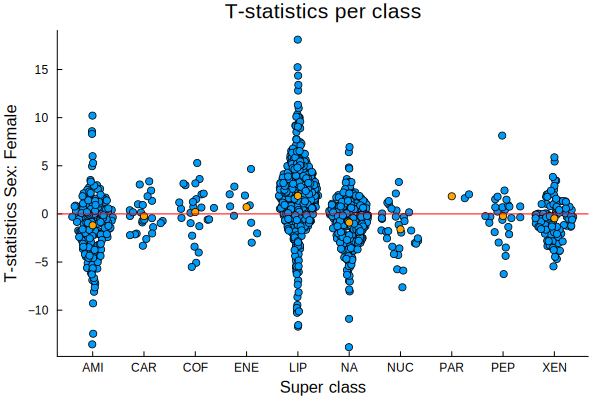

In [221]:
begin
	if @isdefined dfTstatsZI
		nameCovarFig = fix_covar_name(xCovarFig)
		gdf = groupby(dfTstatsZI, :SuperClassID);
		dfMeanTst = combine(gdf, Symbol(nameCovarFig) => mean => Symbol(nameCovarFig)) 
		sort!(dfMeanTst, :SuperClassID);
	
		# var2vis = Symbol("Sex")
		eval(Meta.parse("@df dfTstatsZI dotplot(string.(:SuperClassID), :$(nameCovarFig), legend = false)"))
		eval(Meta.parse("@df dfMeanTst scatter!(string.(:SuperClassID), :$(nameCovarFig), legend = false, color = :orange)"))
		hline!([0], color= :red,
			label = "",
			xlabel = "Super class",
			ylabel = string("T-statistics ", xCovarFig),
			title = "T-statistics per class",
			fontfamily = myfont, grid = false
		)
	end
end

### Association at the super class level

In [222]:
begin
	
if (@isdefined mX)
	###############
	# Super Class #
	###############
	levelsSup = sort(unique(dfRef.SuperClassID));
	# Generate Z matrix
	mZsup = modelmatrix(@formula(y ~ 0 + SuperClassID).rhs, 
						dfRef, 
						hints = Dict(:SuperClassID => StatsModels.FullDummyCoding()));

	# true indicates correct design matrix
	# levelsSup[(mapslices(x ->findall(x .== 1) , mZsup, dims = [2]))[:]] == dfRef.SuperClassID
	CoefZsp, CIZsp, TstatZsp, varZsp = getCoefs(mY, mX, mZsup);	
	
# 	md"""
# 	Show Z matrix $(@bind radio_Zsp CheckBox())
# 	"""		
        
    radio_Zsp = false
end
	
end


false

In [223]:
begin 
if (@isdefined mX)
	if radio_Zsp
		DataFrame(hcat(Int.(mZsup[:,1:end]), dfRef.SuperClassID[:]), vcat(levelsSup, ["Class"]))
	else
		println("Z matrix design is based on super classes.")
	end
end
end

Z matrix design is based on super classes.


In [224]:
vFrmlNames

3-element Vector{String}:
 "(Intercept)"
 "Sex: Female"
 "Site: UIA"

In [225]:
if @isdefined vFrmlNames
	# @bind xCovarFig_sp Select(vFrmlNames)
    xCovarFig_sp = vFrmlNames[2]
end

"Sex: Female"

In [ ]:
begin
	# if @isdefined TstatZsp
	# 	namesX = xCovarFig
	# 	idxCovar = findall(vCovarNames.==xCovarFig)
	# 	namesZsup = string.(permutedims(levelsSup[1:end]))
	# 	plot(transpose(TstatZsp[idxCovar,1:end]), # [:, 1:2]
	# 	    label= namesX, xlabel= "Super Pathway", ylabel = "T-statistics",
	# 	    legend =:outerright, lw = 2, marker = :circle, grid = false,
	# 	    xticks = (collect(1:size(mZsup)[2]), namesZsup),xrotation = 45,
	# 		size = (800,550),
	# 		# size = (650,550),
	# 	    foreground_color_legend = nothing, # remove box of legend   
	# 	    bottom_margin = 10mm, format = :svg, 
	# 	    title = string("T-statistics of Coefficients Estimates") )
	# 	hline!([2], color= :red, label = "")
	# 	hline!([-2], color= :red, label = "")
		
		# namesX = permutedims(vCovarNames[(vCovarNames[1] == "Intercept" ? 2 : 1):end])
		# namesZ = string.(permutedims(levelsSup[1:end]))
		# plot(transpose(TstatZsp[:,1:end])[:,2:end], # [:, 1:2]
		#     label= namesX, xlabel= "Super Pathway", ylabel = "T-statistics",
		#     legend =:outerright, lw = 2, marker = :circle, grid = false,
		#     xticks = (collect(1:size(mZsup)[2]), namesZ),xrotation = 45,
		# 	size = (800,550),
		#     foreground_color_legend = nothing, # remove box of legend   
		#     bottom_margin = 10mm, format = :svg,
		#     title = string("T-statistics of Coefficients Estimates") )
		# hline!([2], color= :red, label = "")
		# hline!([-2], color= :red, label = "")
	end
# end

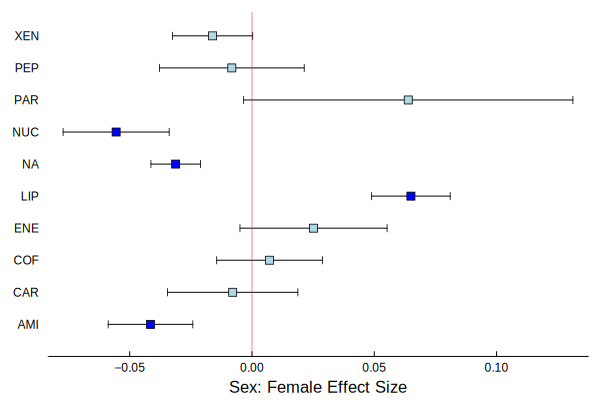

In [198]:
begin
	if @isdefined TstatZsp
		
		idxCovarsup = findall(vPseudoFrmlNames .== fix_covar_name(xCovarFig_sp))
		namesZsup = string.(permutedims(levelsSup[1:end]))
		confidenceplot(
            vec(permutedims(CoefZsp[idxCovarsup,:])), 
			vec(namesZsup),
			vec((CIZsp[idxCovarsup,:])),
			xlabel = xCovarFig_sp*" Effect Size",
			fontfamily = myfont, 
			legend = false,
		)
	end
end

In [75]:
colortest = (x+ε).*(x-ε) .> 0

10-element BitVector:
 1
 0
 0
 0
 1
 1
 1
 0
 0
 0

In [128]:
vtest = (ifelse.(colortest, :blue, :lightblue))

10-element Vector{Symbol}:
 :blue
 :lightblue
 :lightblue
 :lightblue
 :blue
 :blue
 :blue
 :lightblue
 :lightblue
 :lightblue

In [164]:
cgrad([:lightblue, :blue])#, [0.1, 0.3, 0.8])

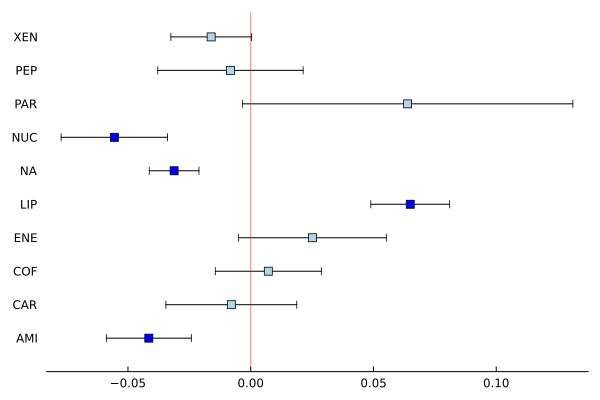

In [196]:
myscheme = [RGB{Float64}(.62, 0.792, 0.882),
            RGB{Float64}(0.192, 0.51, 0.741)]	
mycolors =ColorScheme(myscheme)
	colors = cgrad(mycolors, 2, categorical = true);

scatter(
    x, 
    vec(namesZsup), 
    xerror = ε, 
    legend = false, 
    grid = false, 
    markershape = :rect,
    zcolor = colortest,
    color = cgrad([:lightblue, :blue]),#ifelse.(colortest, :blue, :lightblue),
    # yshowaxis=true,
    y_foreground_color_axis = :white,
    y_foreground_color_border = :white,
    ylims = (-0.5,length(vec(namesZsup))+0.25)
)
vline!([0], color = :red, alpha = 0.5)

In [134]:
Int.(colortest)

10-element Vector{Int64}:
 1
 0
 0
 0
 1
 1
 1
 0
 0
 0

In [ ]:
begin
if (@isdefined TstatZsp) && (xCovariates != ["Intercept"])
	catTstatZsp = zeros(size(TstatZsp,1), size(TstatZsp,2));
	catTstatZsp[findall(abs.(TstatZsp) .<2)].= 0;
	catTstatZsp[findall((TstatZsp .>=2) .&& (TstatZsp .<3))].= 1;
	catTstatZsp[findall((TstatZsp .<=-2) .&& (TstatZsp .>-3))].= -1;
	catTstatZsp[findall(TstatZsp .>=3)].= 2;
	catTstatZsp[findall(TstatZsp .<=-3)].= -2;
	catTstatZsp
	
	# myscheme = [RGB{Float64}(0.792, 0, 0.125),
 #            RGB{Float64}(0.957, 0.647, 0.51),
 #            RGB{Float64}(0.5, 0.5, 0.5),    
 #            RGB{Float64}(0.557, 0.773, 0.871),
 #            RGB{Float64}(0.02, 0.443, 0.69)];

	myscheme = [RGB{Float64}(0.471, 0.161, 0.518),
            RGB{Float64}(0.694, 0.549, 0.761),
            RGB{Float64}(0.5, 0.5, 0.5),    
            RGB{Float64}(0.502, 0.745, 0.49),
            RGB{Float64}(0.114, 0.467, 0.216)];
	# labels
	namesTstsX = vFrmlNames
	namesXtbl = reshape(namesTstsX[2:end], 1, length(namesTstsX)-1)
	# namesTstsX = vCovarNames
	# namesXtbl = reshape(namesTstsX[2:end], 1, length(namesTstsX)-1)
	clrbarticks = ["T-stats ≤ -3", "-3 < T-stats ≤ -2", "-2 < T-stats < 2", "2 ≤ T-stats < 3", "3 ≤ T-stats"];
	n_cat = length(clrbarticks)
	yt = range(0,1,n_cat+1)[1:n_cat] .+ 0.5/n_cat
	# myfont = "Computer Modern" 

	l = @layout [ a{0.50w} [b{0.1h}; c{0.2w}] ];

	mycolors =ColorScheme(myscheme)
	colors = cgrad(mycolors, 5, categorical = true);

	# PLOT MAIN HEATMAP
	p1 = mlmheatmap(permutedims(catTstatZsp[2:end,:]),permutedims(TstatZsp[2:end,:]), 
	    xticks = (collect(1:size(mZsup)[1]), namesXtbl), xrotation = 40,
	    yticks = (collect(1:size(mZsup)[2]), levelsSup), tickfontfamily = myfont ,
	    color = colors, cbar = false,
		clims = (-3, 3),
	    annotationargs = (10, "Arial", :lightgrey), 
	    linecolor = :white , linewidth = 2);

	# PLOT GAP 
	p2 = plot([NaN], lims=(0,1), framestyle=:none, legend=false);

	# ANNOTATE COLOR BAR TITLE
	annotate!(0.5, -3.02, text("T-statistics", 10, myfont))
	
	# PLOT HEATMAP COLOR BAR
	xx = range(0,1,100)
	zz = zero(xx)' .+ xx
	p3 = Plots.heatmap(xx, xx, zz, ticks=false, ratio=3, legend=false, 
	            fc=colors, lims=(0,1), framestyle=:box, right_margin=20mm);
	
	# ANNOTATE COLOR BAR AXIS
	[annotate!(2.15, yi, text(ti, 7, myfont)) for (yi,ti) in zip(yt,clrbarticks)]
	
	# PLOT MLMHEATMAP
	plot(p1, p2, p3, layout=l, margins=4mm)
end
end

In [ ]:
if @isdefined(TstatZsp)
	mlmheatmap(permutedims(TstatZsp[2:end, :]), permutedims(TstatZsp[2:end,:]), 
		    xticks = (collect(1:size(mZsup)[1]), namesXtbl), xrotation = 25,
		    yticks = (collect(1:size(mZsup)[2]), levelsSup), tickfontfamily = myfont ,
		    color = cgrad(:bluesreds,[0.1, 0.3, 0.7, 0.9], alpha = 0.8), cbar = true,
		 	clims = (-3, 3), colorbar_title = "T-statistics",
		    annotationargs = (10, "Arial", :lightgrey), 
		    linecolor = :white , linewidth = 2, margins=8mm)
end

In [ ]:
md"""
### Association at the sub class level
"""

In [ ]:
begin
	
if (@isdefined mX)
	#############
	# Sub Class #
	#############
	levelsSub = sort(unique(dfRef.SubClassID));

	# Generate Z matrix
	mZsub = modelmatrix(@formula(y ~ 0 + SubClassID).rhs, 
						dfRef, 
						hints = Dict(:SubClassID => StatsModels.FullDummyCoding()));	
	# true indicates correct design matrix
	levelsSub[(mapslices(x ->findall(x .== 1) , mZsub, dims = [2]))[:]] == dfRef.SubClassID
	CoefZsb, CIZsb, TstatZsb, varZsb = getCoefs(mY, mX, mZsub);
	
	md"""
	Show Z matrix $(@bind radio_Zsb CheckBox())
	"""		
end
	
end


In [ ]:
begin 
if (@isdefined mX)
	if radio_Zsb
		DataFrame(hcat(Int.(mZsub[:,1:end]), dfRef.SubClassID[:]), vcat(levelsSub, ["Class"]))
	else
		md"Z matrix design is based on sub-classes."
	end
end
end

In [ ]:
if @isdefined vFrmlNames
	@bind xCovarFig_sb Select(vFrmlNames)
end

In [ ]:
begin
	if @isdefined TstatZsb
		
		idxCovarsub = findall(vPseudoFrmlNames .== fix_covar_name(xCovarFig_sb))
		namesZsub = string.(permutedims(levelsSub[1:end]))
		confidenceplot(vec(permutedims(CoefZsb[idxCovarsub,:])), 
				   vec(namesZsub),
				   vec((CIZsb[idxCovarsub,:])),
				   xlabel=xCovarFig*" Effect Size", legend=false,
				   fontfamily = myfont,
				   size=(800,1000), 
		)
	end
end

In [ ]:
if @isdefined(TstatZsb)
	mlmheatmap(permutedims(TstatZsb[2:end, :]), permutedims(TstatZsb[2:end,:]), 
		    xticks = (collect(1:size(mZsub)[1]), namesXtbl), xrotation = 25,
		    yticks = (collect(1:size(mZsub)[2]), levelsSub), tickfontfamily = myfont ,
		    color = cgrad(:bluesreds,[0.1, 0.3, 0.7, 0.9], alpha = 0.8), cbar = true,
		 	clims = (-3, 3), colorbar_title = "T-statistics",
		    annotationargs = (10, "Arial", :lightgrey), 
		    linecolor = :white , linewidth = 2, margins=8mm
	)
end

In [ ]:
begin
	if (@isdefined TstatZsb) 
		# namesX = permutedims(vCovarNames[(vCovarNames[1] == "Intercept" ? 2 : 1):end])
		# namesZsub = string.(permutedims(levelsSub[1:end]))
		# plot(transpose(TstatZsb[idxCovar,1:end]), # [:, 1:2]
		#     label= namesX, xlabel= "Sub Pathway", ylabel = "T-statistics",
		#     legend =:outerright, lw = 2, marker = :circle, grid = false,
		#     xticks = (collect(1:size(mZsub)[2]), namesZsub),xrotation = 45,
		# 	size = (800,550),
		# 	# size = (650,550),
			
		#     foreground_color_legend = nothing, # remove box of legend   
		#     bottom_margin = 10mm, format = :svg,
		#     title = string("T-statistics of Coefficients Estimates") )
		# hline!([2], color= :red, label = "")
		# hline!([-2], color= :red, label = "")
				
		
		# # namesX = permutedims(vCovarNames[(vCovarNames[1] == "Intercept" ? 2 : 1):end])
		# namesZsub = string.(permutedims(levelsSub[1:end]))
		# plot(transpose(TstatZsb[:,1:end])[:,2:end], # [:, 1:2]
		#     label= namesX, xlabel= "Super Pathway", ylabel = "T-statistics",
		#     legend =:outerright, lw = 2, marker = :circle, grid = false,
		#     xticks = (collect(1:size(mZsub)[2]), namesZsub),xrotation = 45,
		# 	size = (800,550),
		#     foreground_color_legend = nothing, # remove box of legend   
		#     bottom_margin = 10mm, format = :svg,
		#     title = string("T-statistics of Coefficients Estimates") )
		# hline!([2], color= :red, label = "")
		# hline!([-2], color= :red, label = "")
	end
end

In [ ]:
md"""
### Association at the Modules level
"""

In [ ]:
begin
	
if (@isdefined mX)
	######################
	# Metabolite Classes #
	######################
	# nameModules = ["blue", "red", "turquoise", "brown", "yellow","green",
	# 			"magenta", "black", "greenyellow", "purple", "pink"]
	nameModules =  ["pink", "purple", "greenyellow", "black", "magenta", "green",
		"yellow", "brown", "turquoise", "red", "blue"]

	# remove cols with NA class Metabolites in mY
	idx_noNA = findall(dfRef.SuperPathway .!= "NA")
	mY_noNA = mY[:, idx_noNA];
	dfRef_noNA = filter(row-> row.SuperPathway != "NA", dfRef)
	dfZmodule = select(dfRef_noNA, [:CompID, :SubPathway, :SuperPathway])
	
	# dfZmodule = select(dfRef, [:CompID, :SubPathway, :SuperPathway])
	
	# blue	
	idx_blue = findall(occursin.(r"Dicarboxylate|Monohydroxy|Long Chain|Medium Chain|Acyl Carnitines|Endocannabinoid", dfZmodule.SubPathway))
	idx_blue = vcat(idx_blue, findall(occursin.(r"Nucleotide", dfZmodule.SuperPathway)))
	
	# red
	idx_red = findall(occursin.(r"Ceramide|Sphingomyelin", dfZmodule.SubPathway))
	
	# turquoise
	idx_turquoise = findall(occursin.(r"Tryptophan|Glutamate|Histidine|Glycine|Serine|Threonine|Methionine|Cysteine|SAM|Taurine|Polyamine|Urea|Arginine|Proline|TCA Cycle|Leucine|Isoleucine|Valine", dfZmodule.SubPathway))
	idx_turquoise = vcat(idx_turquoise, findall(occursin.(r"Xenobiotics", dfZmodule.SuperPathway)))
	# NOTES: Branched Chain Amino Acids: |Leucine|Isoleucine|Valine
		
	# brown
	idx_brown = findall(occursin.(r"Gamma-glutamyl|Glutamate|Urea|Lysine|Methionine|Phenylalanine|Bile Acid|Acyl Choline|Lysophospholipid|Leucine|Isoleucine|Valine", dfZmodule.SubPathway))
	# NOTES: Branched Chain Amino Acids: |Leucine|Isoleucine|Valine
		
	# yellow
	idx_yellow = findall(occursin.(r"Benzoate|Xanthine Metabolism|Food", dfZmodule.SubPathway))
	
	# green
	idx_green = findall(occursin.(r"Lysophospholipid|Phosphatidylcholine|Phosphatidylinositol|Plasmalogen", dfZmodule.SubPathway))
	
	# magenta
	idx_magenta = findall(occursin.(r"Androgenic|Pregnenolone|Corticosteroid|Progestin", dfZmodule.SubPathway))
	
	# black
	idx_black = findall(occursin.(r"Diacylglycerol|Phosphatidylethanolamine|Acyl Carnitine", dfZmodule.SubPathway))
	
	# greenyellow
	idx_greenyellow = findall(occursin.(r"Cofactors and Vitamins", dfZmodule.SuperPathway))
	
	# purple
	idx_purple = findall(occursin.(r"Acetylated Peptides|Benzoate|Secondary Bile Acid", dfZmodule.SubPathway))
	
	# pink
	idx_pink = findall(occursin.(r"Chemical|Dipeptide|Hemoglobin", dfZmodule.SubPathway))
	
	# idx_modules = (idx_blue, idx_red, idx_turquoise, idx_brown, idx_yellow, idx_green,
	# 				idx_magenta, idx_black, idx_greenyellow, idx_purple, idx_pink);
	idx_modules = (idx_pink, idx_purple, idx_greenyellow, idx_black, idx_magenta, idx_green, idx_yellow, idx_brown, idx_turquoise, idx_red, idx_blue);
	
	
	# Generate Z modules matrix
	# mZmdl = zeros(Int,size(dfRef, 1), length(idx_modules))
	mZmdl = zeros(Int,size(dfRef_noNA, 1), length(idx_modules))
	
	for i in 1:length(idx_modules)
		mZmdl[idx_modules[i] ,i] .= 1
	end

	# CoefZmdl, CIZmdl, TstatZmdl, varZmdl = getCoefs(mY, mX, mZmdl);
	CoefZmdl, CIZmdl, TstatZmdl, varZmdl = getCoefs(mY_noNA, mX, mZmdl);
	
	md"""
	Show Z matrix $(@bind radio_Zmdl CheckBox())
	"""		
end
	
end

In [ ]:
begin 
if (@isdefined mX)
	if radio_Zmdl
		DataFrame(Int.(mZmdl[:,1:end]), nameModules)
	else
		md"Z matrix design is based on modules."
	end
end
end

In [ ]:
if @isdefined vFrmlNames
	@bind xCovarFig_mdl Select(vFrmlNames)
end

In [ ]:
begin
	if @isdefined TstatZmdl
		
		idxCovarmdl = findall(vPseudoFrmlNames .== fix_covar_name(xCovarFig_mdl))
		namesZmdl = string.(permutedims(nameModules[1:end]))
		confidenceplot(vec(permutedims(CoefZmdl[idxCovarmdl,:])), 
				   vec(namesZmdl),
				   vec((CIZmdl[idxCovarmdl,:])),
				   xlabel=xCovarFig*" Effect Size", legend=false,
				   fontfamily = myfont,
				   # size=(600,800), 
		)
	end
end

In [ ]:
begin
	if (@isdefined TstatZmdl) 
		# namesX = permutedims(vCovarNames[(vCovarNames[1] == "Intercept" ? 2 : 1):end])
		# namesZmdl = string.(permutedims(nameModules))
		# plot(transpose(TstatZmdl[idxCovar,1:end]), # [:, 1:2]
		#     label= namesX, xlabel= "Metabolite Classes by module", ylabel = "T-statistics",
		#     legend =:outerright, lw = 2, marker = :circle, grid = false,
		#     xticks = (collect(1:size(mZmdl)[2]), namesZmdl),xrotation = 45,
		# 	size = (800,550),
		# 	# size = (650,550),
			
		#     foreground_color_legend = nothing, # remove box of legend   
		#     bottom_margin = 10mm, format = :svg,
		#     title = string("T-statistics of Coefficients Estimates") )
		# hline!([2], color= :red, label = "")
		# hline!([-2], color= :red, label = "")
				
		
		# # namesX = permutedims(vCovarNames[(vCovarNames[1] == "Intercept" ? 2 : 1):end])
		# namesZsub = string.(permutedims(levelsSub[1:end]))
		# plot(transpose(TstatZsb[:,1:end])[:,2:end], # [:, 1:2]
		#     label= namesX, xlabel= "Super Pathway", ylabel = "T-statistics",
		#     legend =:outerright, lw = 2, marker = :circle, grid = false,
		#     xticks = (collect(1:size(mZsub)[2]), namesZsub),xrotation = 45,
		# 	size = (800,550),
		#     foreground_color_legend = nothing, # remove box of legend   
		#     bottom_margin = 10mm, format = :svg,
		#     title = string("T-statistics of Coefficients Estimates") )
		# hline!([2], color= :red, label = "")
		# hline!([-2], color= :red, label = "")
	end
end

In [ ]:
let
if (@isdefined TstatZmdl) && (xCovariates != ["Intercept"])
	catTstatZmdl = zeros(size(TstatZmdl,1), size(TstatZmdl,2));
	catTstatZmdl[findall(abs.(TstatZmdl) .<2)].= 0;
	catTstatZmdl[findall((TstatZmdl .>=2) .&& (TstatZmdl .<3))].= 1;
	catTstatZmdl[findall((TstatZmdl .<=-2) .&& (TstatZmdl .>-3))].= -1;
	catTstatZmdl[findall(TstatZmdl .>=3)].= 2;
	catTstatZmdl[findall(TstatZmdl .<=-3)].= -2;
	catTstatZmdl
	
	# myscheme = [RGB{Float64}(0.792, 0, 0.125),
 #            RGB{Float64}(0.957, 0.647, 0.51),
 #            RGB{Float64}(0.5, 0.5, 0.5),    
 #            RGB{Float64}(0.557, 0.773, 0.871),
 #            RGB{Float64}(0.02, 0.443, 0.69)];
	# labels
	# namesTstsX = vCovarNames
	# namesXtbl = reshape(namesTstsX[2:end], 1, length(namesTstsX)-1)
	# clrbarticks = ["T-stats ≤ -3", "-3 < T-stats ≤ -2", "-2 < T-stats < 2", "2 ≤ T-stats < 3", "3 ≤ T-stats"];
	# n_cat = length(clrbarticks)
	# yt = range(0,1,n_cat+1)[1:n_cat] .+ 0.5/n_cat
	# myfont = "Computer Modern" 

	# l = @layout [ a{0.50w} [b{0.1h}; c{0.2w}] ];

	# mycolors =ColorScheme(myscheme)
	# colors = cgrad(mycolors, 5, categorical = true);

	# PLOT MAIN HEATMAP
	p1 = mlmheatmap(permutedims(catTstatZmdl[2:end,:]), permutedims(TstatZmdl[2:end,:]), 
	    xticks = (collect(1:size(mZmdl)[1]), namesXtbl), xrotation = 25,
	    yticks = (collect(1:size(mZmdl)[2]), nameModules), tickfontfamily = myfont ,
	    color = colors, cbar = false,
		clims = (-3, 3),
	    annotationargs = (10, "Arial", :lightgrey), 
	    linecolor = :white , linewidth = 2);

	# PLOT GAP 
	p2 = plot([NaN], lims=(0,1), framestyle=:none, legend=false);

	# ANNOTATE COLOR BAR TITLE
	annotate!(0.5, -3.02, text("T-statistics", 10, myfont))
	
	# PLOT HEATMAP COLOR BAR
	xx = range(0,1,100)
	zz = zero(xx)' .+ xx
	p3 = Plots.heatmap(xx, xx, zz, ticks=false, ratio=3, legend=false, 
	            fc=colors, lims=(0,1), framestyle=:box, right_margin=15mm);
	
	# ANNOTATE COLOR BAR AXIS
	[annotate!(2.15, yi, text(ti, 7, myfont)) for (yi,ti) in zip(yt,clrbarticks)]
	
	# PLOT MLMHEATMAP
	plot(p1, p2, p3, layout=l, margins=2mm)
end
end

In [ ]:
md"""
## References

	Dieterle F, Ross A, Schlotterbeck G, Senn H. Probabilistic Quotient Normalization as Robust Method to Account for Dilution of Complex Biological Mixtures. Application in 1H NMR Metabonomics. Analytical Chemistry. 2006;78: 4281–4290. doi:10.1021/ac051632c

	Gillenwater, Lucas A., Katerina J. Kechris, Katherine A. Pratte, Nichole Reisdorph, Irina Petrache, Wassim W. Labaki, Wanda O’Neal, Jerry A. Krishnan, Victor E. Ortega, Dawn L. DeMeo, and Russell P. Bowler. 2021. "Metabolomic Profiling Reveals Sex Specific Associations with Chronic Obstructive Pulmonary Disease and Emphysema" Metabolites 11, no. 3: 161. [https://doi.org/10.3390/metabo11030161](https://doi.org/10.3390/metabo11030161)

	Hastie, T., Tibshirani, R., Sherlock, G., Eisen, M., Brown, P. and Botstein, D., Imputing Missing Data for Gene Expression Arrays, Stanford University Statistics Department Technical report (1999), http://www-stat.stanford.edu/~hastie/Papers/missing.pdf Olga Troyanskaya, Michael Cantor, Gavin Sherlock, Pat Brown, Trevor Hastie, Robert Tibshirani, David Botstein and Russ B. Altman, Missing value estimation methods for DNA microarrays BIOINFORMATICS Vol. 17 no. 6, 2001 Pages 520-525
"""

In [ ]:
PLUTO_PROJECT_TOML_CONTENTS = """
[deps]
CSV = "336ed68f-0bac-5ca0-87d4-7b16caf5d00b"
ColorSchemes = "35d6a980-a343-548e-a6ea-1d62b119f2f4"
DataFrames = "a93c6f00-e57d-5684-b7b6-d8193f3e46c0"
DataFramesMeta = "1313f7d8-7da2-5740-9ea0-a2ca25f37964"
Distributions = "31c24e10-a181-5473-b8eb-7969acd0382f"
FileIO = "5789e2e9-d7fb-5bc7-8068-2c6fae9b9549"
FreqTables = "da1fdf0e-e0ff-5433-a45f-9bb5ff651cb1"
Images = "916415d5-f1e6-5110-898d-aaa5f9f070e0"
Latexify = "23fbe1c1-3f47-55db-b15f-69d7ec21a316"
LinearAlgebra = "37e2e46d-f89d-539d-b4ee-838fcccc9c8e"
MatrixLM = "37290134-6146-11e9-0c71-a5c489be1f53"
Missings = "e1d29d7a-bbdc-5cf2-9ac0-f12de2c33e28"
Plots = "91a5bcdd-55d7-5caf-9e0b-520d859cae80"
PlutoUI = "7f904dfe-b85e-4ff6-b463-dae2292396a8"
PrettyTables = "08abe8d2-0d0c-5749-adfa-8a2ac140af0d"
Random = "9a3f8284-a2c9-5f02-9a11-845980a1fd5c"
RecipesBase = "3cdcf5f2-1ef4-517c-9805-6587b60abb01"
Statistics = "10745b16-79ce-11e8-11f9-7d13ad32a3b2"
StatsBase = "2913bbd2-ae8a-5f71-8c99-4fb6c76f3a91"
StatsModels = "3eaba693-59b7-5ba5-a881-562e759f1c8d"
StatsPlots = "f3b207a7-027a-5e70-b257-86293d7955fd"

[compat]
CSV = "~0.10.7"
ColorSchemes = "~3.20.0"
DataFrames = "~1.4.3"
DataFramesMeta = "~0.12.0"
Distributions = "~0.25.79"
FileIO = "~1.16.0"
FreqTables = "~0.4.5"
Images = "~0.25.2"
Latexify = "~0.15.17"
MatrixLM = "~0.1.3"
Missings = "~1.0.2"
Plots = "~1.36.6"
PlutoUI = "~0.7.48"
PrettyTables = "~2.2.1"
RecipesBase = "~1.3.1"
StatsBase = "~0.33.21"
StatsModels = "~0.6.33"
StatsPlots = "~0.15.4"
"""

In [ ]:
PLUTO_MANIFEST_TOML_CONTENTS = """
# This file is machine-generated - editing it directly is not advised

julia_version = "1.8.3"
manifest_format = "2.0"
project_hash = "e6da4c6db35419d0e04de959a4792d5e39939047"

[[deps.AbstractFFTs]]
deps = ["ChainRulesCore", "LinearAlgebra"]
git-tree-sha1 = "69f7020bd72f069c219b5e8c236c1fa90d2cb409"
uuid = "621f4979-c628-5d54-868e-fcf4e3e8185c"
version = "1.2.1"

[[deps.AbstractPlutoDingetjes]]
deps = ["Pkg"]
git-tree-sha1 = "8eaf9f1b4921132a4cff3f36a1d9ba923b14a481"
uuid = "6e696c72-6542-2067-7265-42206c756150"
version = "1.1.4"

[[deps.Adapt]]
deps = ["LinearAlgebra"]
git-tree-sha1 = "195c5505521008abea5aee4f96930717958eac6f"
uuid = "79e6a3ab-5dfb-504d-930d-738a2a938a0e"
version = "3.4.0"

[[deps.ArgTools]]
uuid = "0dad84c5-d112-42e6-8d28-ef12dabb789f"
version = "1.1.1"

[[deps.ArnoldiMethod]]
deps = ["LinearAlgebra", "Random", "StaticArrays"]
git-tree-sha1 = "62e51b39331de8911e4a7ff6f5aaf38a5f4cc0ae"
uuid = "ec485272-7323-5ecc-a04f-4719b315124d"
version = "0.2.0"

[[deps.Arpack]]
deps = ["Arpack_jll", "Libdl", "LinearAlgebra", "Logging"]
git-tree-sha1 = "9b9b347613394885fd1c8c7729bfc60528faa436"
uuid = "7d9fca2a-8960-54d3-9f78-7d1dccf2cb97"
version = "0.5.4"

[[deps.Arpack_jll]]
deps = ["Artifacts", "CompilerSupportLibraries_jll", "JLLWrappers", "Libdl", "OpenBLAS_jll", "Pkg"]
git-tree-sha1 = "5ba6c757e8feccf03a1554dfaf3e26b3cfc7fd5e"
uuid = "68821587-b530-5797-8361-c406ea357684"
version = "3.5.1+1"

[[deps.Artifacts]]
uuid = "56f22d72-fd6d-98f1-02f0-08ddc0907c33"

[[deps.AxisAlgorithms]]
deps = ["LinearAlgebra", "Random", "SparseArrays", "WoodburyMatrices"]
git-tree-sha1 = "66771c8d21c8ff5e3a93379480a2307ac36863f7"
uuid = "13072b0f-2c55-5437-9ae7-d433b7a33950"
version = "1.0.1"

[[deps.AxisArrays]]
deps = ["Dates", "IntervalSets", "IterTools", "RangeArrays"]
git-tree-sha1 = "1dd4d9f5beebac0c03446918741b1a03dc5e5788"
uuid = "39de3d68-74b9-583c-8d2d-e117c070f3a9"
version = "0.4.6"

[[deps.Base64]]
uuid = "2a0f44e3-6c83-55bd-87e4-b1978d98bd5f"

[[deps.BitFlags]]
git-tree-sha1 = "43b1a4a8f797c1cddadf60499a8a077d4af2cd2d"
uuid = "d1d4a3ce-64b1-5f1a-9ba4-7e7e69966f35"
version = "0.1.7"

[[deps.Bzip2_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg"]
git-tree-sha1 = "19a35467a82e236ff51bc17a3a44b69ef35185a2"
uuid = "6e34b625-4abd-537c-b88f-471c36dfa7a0"
version = "1.0.8+0"

[[deps.CEnum]]
git-tree-sha1 = "eb4cb44a499229b3b8426dcfb5dd85333951ff90"
uuid = "fa961155-64e5-5f13-b03f-caf6b980ea82"
version = "0.4.2"

[[deps.CSV]]
deps = ["CodecZlib", "Dates", "FilePathsBase", "InlineStrings", "Mmap", "Parsers", "PooledArrays", "SentinelArrays", "Tables", "Unicode", "WeakRefStrings"]
git-tree-sha1 = "c5fd7cd27ac4aed0acf4b73948f0110ff2a854b2"
uuid = "336ed68f-0bac-5ca0-87d4-7b16caf5d00b"
version = "0.10.7"

[[deps.Cairo_jll]]
deps = ["Artifacts", "Bzip2_jll", "Fontconfig_jll", "FreeType2_jll", "Glib_jll", "JLLWrappers", "LZO_jll", "Libdl", "Pixman_jll", "Pkg", "Xorg_libXext_jll", "Xorg_libXrender_jll", "Zlib_jll", "libpng_jll"]
git-tree-sha1 = "4b859a208b2397a7a623a03449e4636bdb17bcf2"
uuid = "83423d85-b0ee-5818-9007-b63ccbeb887a"
version = "1.16.1+1"

[[deps.Calculus]]
deps = ["LinearAlgebra"]
git-tree-sha1 = "f641eb0a4f00c343bbc32346e1217b86f3ce9dad"
uuid = "49dc2e85-a5d0-5ad3-a950-438e2897f1b9"
version = "0.5.1"

[[deps.CatIndices]]
deps = ["CustomUnitRanges", "OffsetArrays"]
git-tree-sha1 = "a0f80a09780eed9b1d106a1bf62041c2efc995bc"
uuid = "aafaddc9-749c-510e-ac4f-586e18779b91"
version = "0.2.2"

[[deps.CategoricalArrays]]
deps = ["DataAPI", "Future", "Missings", "Printf", "Requires", "Statistics", "Unicode"]
git-tree-sha1 = "5084cc1a28976dd1642c9f337b28a3cb03e0f7d2"
uuid = "324d7699-5711-5eae-9e2f-1d82baa6b597"
version = "0.10.7"

[[deps.Chain]]
git-tree-sha1 = "8c4920235f6c561e401dfe569beb8b924adad003"
uuid = "8be319e6-bccf-4806-a6f7-6fae938471bc"
version = "0.5.0"

[[deps.ChainRulesCore]]
deps = ["Compat", "LinearAlgebra", "SparseArrays"]
git-tree-sha1 = "e7ff6cadf743c098e08fca25c91103ee4303c9bb"
uuid = "d360d2e6-b24c-11e9-a2a3-2a2ae2dbcce4"
version = "1.15.6"

[[deps.ChangesOfVariables]]
deps = ["ChainRulesCore", "LinearAlgebra", "Test"]
git-tree-sha1 = "38f7a08f19d8810338d4f5085211c7dfa5d5bdd8"
uuid = "9e997f8a-9a97-42d5-a9f1-ce6bfc15e2c0"
version = "0.1.4"

[[deps.Clustering]]
deps = ["Distances", "LinearAlgebra", "NearestNeighbors", "Printf", "Random", "SparseArrays", "Statistics", "StatsBase"]
git-tree-sha1 = "64df3da1d2a26f4de23871cd1b6482bb68092bd5"
uuid = "aaaa29a8-35af-508c-8bc3-b662a17a0fe5"
version = "0.14.3"

[[deps.CodecZlib]]
deps = ["TranscodingStreams", "Zlib_jll"]
git-tree-sha1 = "ded953804d019afa9a3f98981d99b33e3db7b6da"
uuid = "944b1d66-785c-5afd-91f1-9de20f533193"
version = "0.7.0"

[[deps.ColorSchemes]]
deps = ["ColorTypes", "ColorVectorSpace", "Colors", "FixedPointNumbers", "Random", "SnoopPrecompile"]
git-tree-sha1 = "aa3edc8f8dea6cbfa176ee12f7c2fc82f0608ed3"
uuid = "35d6a980-a343-548e-a6ea-1d62b119f2f4"
version = "3.20.0"

[[deps.ColorTypes]]
deps = ["FixedPointNumbers", "Random"]
git-tree-sha1 = "eb7f0f8307f71fac7c606984ea5fb2817275d6e4"
uuid = "3da002f7-5984-5a60-b8a6-cbb66c0b333f"
version = "0.11.4"

[[deps.ColorVectorSpace]]
deps = ["ColorTypes", "FixedPointNumbers", "LinearAlgebra", "SpecialFunctions", "Statistics", "TensorCore"]
git-tree-sha1 = "d08c20eef1f2cbc6e60fd3612ac4340b89fea322"
uuid = "c3611d14-8923-5661-9e6a-0046d554d3a4"
version = "0.9.9"

[[deps.Colors]]
deps = ["ColorTypes", "FixedPointNumbers", "Reexport"]
git-tree-sha1 = "417b0ed7b8b838aa6ca0a87aadf1bb9eb111ce40"
uuid = "5ae59095-9a9b-59fe-a467-6f913c188581"
version = "0.12.8"

[[deps.Combinatorics]]
git-tree-sha1 = "08c8b6831dc00bfea825826be0bc8336fc369860"
uuid = "861a8166-3701-5b0c-9a16-15d98fcdc6aa"
version = "1.0.2"

[[deps.Compat]]
deps = ["Dates", "LinearAlgebra", "UUIDs"]
git-tree-sha1 = "aaabba4ce1b7f8a9b34c015053d3b1edf60fa49c"
uuid = "34da2185-b29b-5c13-b0c7-acf172513d20"
version = "4.4.0"

[[deps.CompilerSupportLibraries_jll]]
deps = ["Artifacts", "Libdl"]
uuid = "e66e0078-7015-5450-92f7-15fbd957f2ae"
version = "0.5.2+0"

[[deps.ComputationalResources]]
git-tree-sha1 = "52cb3ec90e8a8bea0e62e275ba577ad0f74821f7"
uuid = "ed09eef8-17a6-5b46-8889-db040fac31e3"
version = "0.3.2"

[[deps.Contour]]
git-tree-sha1 = "d05d9e7b7aedff4e5b51a029dced05cfb6125781"
uuid = "d38c429a-6771-53c6-b99e-75d170b6e991"
version = "0.6.2"

[[deps.CoordinateTransformations]]
deps = ["LinearAlgebra", "StaticArrays"]
git-tree-sha1 = "681ea870b918e7cff7111da58791d7f718067a19"
uuid = "150eb455-5306-5404-9cee-2592286d6298"
version = "0.6.2"

[[deps.Crayons]]
git-tree-sha1 = "249fe38abf76d48563e2f4556bebd215aa317e15"
uuid = "a8cc5b0e-0ffa-5ad4-8c14-923d3ee1735f"
version = "4.1.1"

[[deps.CustomUnitRanges]]
git-tree-sha1 = "1a3f97f907e6dd8983b744d2642651bb162a3f7a"
uuid = "dc8bdbbb-1ca9-579f-8c36-e416f6a65cce"
version = "1.0.2"

[[deps.DataAPI]]
git-tree-sha1 = "e08915633fcb3ea83bf9d6126292e5bc5c739922"
uuid = "9a962f9c-6df0-11e9-0e5d-c546b8b5ee8a"
version = "1.13.0"

[[deps.DataFrames]]
deps = ["Compat", "DataAPI", "Future", "InvertedIndices", "IteratorInterfaceExtensions", "LinearAlgebra", "Markdown", "Missings", "PooledArrays", "PrettyTables", "Printf", "REPL", "Random", "Reexport", "SnoopPrecompile", "SortingAlgorithms", "Statistics", "TableTraits", "Tables", "Unicode"]
git-tree-sha1 = "0f44494fe4271cc966ac4fea524111bef63ba86c"
uuid = "a93c6f00-e57d-5684-b7b6-d8193f3e46c0"
version = "1.4.3"

[[deps.DataFramesMeta]]
deps = ["Chain", "DataFrames", "MacroTools", "OrderedCollections", "Reexport"]
git-tree-sha1 = "a70c340c1306febfd770a932218561b5e19cf0f6"
uuid = "1313f7d8-7da2-5740-9ea0-a2ca25f37964"
version = "0.12.0"

[[deps.DataStructures]]
deps = ["Compat", "InteractiveUtils", "OrderedCollections"]
git-tree-sha1 = "d1fff3a548102f48987a52a2e0d114fa97d730f0"
uuid = "864edb3b-99cc-5e75-8d2d-829cb0a9cfe8"
version = "0.18.13"

[[deps.DataValueInterfaces]]
git-tree-sha1 = "bfc1187b79289637fa0ef6d4436ebdfe6905cbd6"
uuid = "e2d170a0-9d28-54be-80f0-106bbe20a464"
version = "1.0.0"

[[deps.DataValues]]
deps = ["DataValueInterfaces", "Dates"]
git-tree-sha1 = "d88a19299eba280a6d062e135a43f00323ae70bf"
uuid = "e7dc6d0d-1eca-5fa6-8ad6-5aecde8b7ea5"
version = "0.4.13"

[[deps.Dates]]
deps = ["Printf"]
uuid = "ade2ca70-3891-5945-98fb-dc099432e06a"

[[deps.DelimitedFiles]]
deps = ["Mmap"]
uuid = "8bb1440f-4735-579b-a4ab-409b98df4dab"

[[deps.DensityInterface]]
deps = ["InverseFunctions", "Test"]
git-tree-sha1 = "80c3e8639e3353e5d2912fb3a1916b8455e2494b"
uuid = "b429d917-457f-4dbc-8f4c-0cc954292b1d"
version = "0.4.0"

[[deps.Distances]]
deps = ["LinearAlgebra", "SparseArrays", "Statistics", "StatsAPI"]
git-tree-sha1 = "3258d0659f812acde79e8a74b11f17ac06d0ca04"
uuid = "b4f34e82-e78d-54a5-968a-f98e89d6e8f7"
version = "0.10.7"

[[deps.Distributed]]
deps = ["Random", "Serialization", "Sockets"]
uuid = "8ba89e20-285c-5b6f-9357-94700520ee1b"

[[deps.Distributions]]
deps = ["ChainRulesCore", "DensityInterface", "FillArrays", "LinearAlgebra", "PDMats", "Printf", "QuadGK", "Random", "SparseArrays", "SpecialFunctions", "Statistics", "StatsBase", "StatsFuns", "Test"]
git-tree-sha1 = "a7756d098cbabec6b3ac44f369f74915e8cfd70a"
uuid = "31c24e10-a181-5473-b8eb-7969acd0382f"
version = "0.25.79"

[[deps.DocStringExtensions]]
deps = ["LibGit2"]
git-tree-sha1 = "c36550cb29cbe373e95b3f40486b9a4148f89ffd"
uuid = "ffbed154-4ef7-542d-bbb7-c09d3a79fcae"
version = "0.9.2"

[[deps.Downloads]]
deps = ["ArgTools", "FileWatching", "LibCURL", "NetworkOptions"]
uuid = "f43a241f-c20a-4ad4-852c-f6b1247861c6"
version = "1.6.0"

[[deps.DualNumbers]]
deps = ["Calculus", "NaNMath", "SpecialFunctions"]
git-tree-sha1 = "5837a837389fccf076445fce071c8ddaea35a566"
uuid = "fa6b7ba4-c1ee-5f82-b5fc-ecf0adba8f74"
version = "0.6.8"

[[deps.Expat_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg"]
git-tree-sha1 = "bad72f730e9e91c08d9427d5e8db95478a3c323d"
uuid = "2e619515-83b5-522b-bb60-26c02a35a201"
version = "2.4.8+0"

[[deps.FFMPEG]]
deps = ["FFMPEG_jll"]
git-tree-sha1 = "b57e3acbe22f8484b4b5ff66a7499717fe1a9cc8"
uuid = "c87230d0-a227-11e9-1b43-d7ebe4e7570a"
version = "0.4.1"

[[deps.FFMPEG_jll]]
deps = ["Artifacts", "Bzip2_jll", "FreeType2_jll", "FriBidi_jll", "JLLWrappers", "LAME_jll", "Libdl", "Ogg_jll", "OpenSSL_jll", "Opus_jll", "PCRE2_jll", "Pkg", "Zlib_jll", "libaom_jll", "libass_jll", "libfdk_aac_jll", "libvorbis_jll", "x264_jll", "x265_jll"]
git-tree-sha1 = "74faea50c1d007c85837327f6775bea60b5492dd"
uuid = "b22a6f82-2f65-5046-a5b2-351ab43fb4e5"
version = "4.4.2+2"

[[deps.FFTViews]]
deps = ["CustomUnitRanges", "FFTW"]
git-tree-sha1 = "cbdf14d1e8c7c8aacbe8b19862e0179fd08321c2"
uuid = "4f61f5a4-77b1-5117-aa51-3ab5ef4ef0cd"
version = "0.3.2"

[[deps.FFTW]]
deps = ["AbstractFFTs", "FFTW_jll", "LinearAlgebra", "MKL_jll", "Preferences", "Reexport"]
git-tree-sha1 = "90630efff0894f8142308e334473eba54c433549"
uuid = "7a1cc6ca-52ef-59f5-83cd-3a7055c09341"
version = "1.5.0"

[[deps.FFTW_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg"]
git-tree-sha1 = "c6033cc3892d0ef5bb9cd29b7f2f0331ea5184ea"
uuid = "f5851436-0d7a-5f13-b9de-f02708fd171a"
version = "3.3.10+0"

[[deps.FileIO]]
deps = ["Pkg", "Requires", "UUIDs"]
git-tree-sha1 = "7be5f99f7d15578798f338f5433b6c432ea8037b"
uuid = "5789e2e9-d7fb-5bc7-8068-2c6fae9b9549"
version = "1.16.0"

[[deps.FilePathsBase]]
deps = ["Compat", "Dates", "Mmap", "Printf", "Test", "UUIDs"]
git-tree-sha1 = "e27c4ebe80e8699540f2d6c805cc12203b614f12"
uuid = "48062228-2e41-5def-b9a4-89aafe57970f"
version = "0.9.20"

[[deps.FileWatching]]
uuid = "7b1f6079-737a-58dc-b8bc-7a2ca5c1b5ee"

[[deps.FillArrays]]
deps = ["LinearAlgebra", "Random", "SparseArrays", "Statistics"]
git-tree-sha1 = "802bfc139833d2ba893dd9e62ba1767c88d708ae"
uuid = "1a297f60-69ca-5386-bcde-b61e274b549b"
version = "0.13.5"

[[deps.FixedPointNumbers]]
deps = ["Statistics"]
git-tree-sha1 = "335bfdceacc84c5cdf16aadc768aa5ddfc5383cc"
uuid = "53c48c17-4a7d-5ca2-90c5-79b7896eea93"
version = "0.8.4"

[[deps.Fontconfig_jll]]
deps = ["Artifacts", "Bzip2_jll", "Expat_jll", "FreeType2_jll", "JLLWrappers", "Libdl", "Libuuid_jll", "Pkg", "Zlib_jll"]
git-tree-sha1 = "21efd19106a55620a188615da6d3d06cd7f6ee03"
uuid = "a3f928ae-7b40-5064-980b-68af3947d34b"
version = "2.13.93+0"

[[deps.Formatting]]
deps = ["Printf"]
git-tree-sha1 = "8339d61043228fdd3eb658d86c926cb282ae72a8"
uuid = "59287772-0a20-5a39-b81b-1366585eb4c0"
version = "0.4.2"

[[deps.FreeType2_jll]]
deps = ["Artifacts", "Bzip2_jll", "JLLWrappers", "Libdl", "Pkg", "Zlib_jll"]
git-tree-sha1 = "87eb71354d8ec1a96d4a7636bd57a7347dde3ef9"
uuid = "d7e528f0-a631-5988-bf34-fe36492bcfd7"
version = "2.10.4+0"

[[deps.FreqTables]]
deps = ["CategoricalArrays", "Missings", "NamedArrays", "Tables"]
git-tree-sha1 = "488ad2dab30fd2727ee65451f790c81ed454666d"
uuid = "da1fdf0e-e0ff-5433-a45f-9bb5ff651cb1"
version = "0.4.5"

[[deps.FriBidi_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg"]
git-tree-sha1 = "aa31987c2ba8704e23c6c8ba8a4f769d5d7e4f91"
uuid = "559328eb-81f9-559d-9380-de523a88c83c"
version = "1.0.10+0"

[[deps.Future]]
deps = ["Random"]
uuid = "9fa8497b-333b-5362-9e8d-4d0656e87820"

[[deps.GLFW_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Libglvnd_jll", "Pkg", "Xorg_libXcursor_jll", "Xorg_libXi_jll", "Xorg_libXinerama_jll", "Xorg_libXrandr_jll"]
git-tree-sha1 = "d972031d28c8c8d9d7b41a536ad7bb0c2579caca"
uuid = "0656b61e-2033-5cc2-a64a-77c0f6c09b89"
version = "3.3.8+0"

[[deps.GLM]]
deps = ["Distributions", "LinearAlgebra", "Printf", "Reexport", "SparseArrays", "SpecialFunctions", "Statistics", "StatsAPI", "StatsBase", "StatsFuns", "StatsModels"]
git-tree-sha1 = "884477b9886a52a84378275737e2823a5c98e349"
uuid = "38e38edf-8417-5370-95a0-9cbb8c7f171a"
version = "1.8.1"

[[deps.GR]]
deps = ["Artifacts", "Base64", "DelimitedFiles", "Downloads", "GR_jll", "HTTP", "JSON", "Libdl", "LinearAlgebra", "Pkg", "Preferences", "Printf", "Random", "Serialization", "Sockets", "TOML", "Tar", "Test", "UUIDs", "p7zip_jll"]
git-tree-sha1 = "051072ff2accc6e0e87b708ddee39b18aa04a0bc"
uuid = "28b8d3ca-fb5f-59d9-8090-bfdbd6d07a71"
version = "0.71.1"

[[deps.GR_jll]]
deps = ["Artifacts", "Bzip2_jll", "Cairo_jll", "FFMPEG_jll", "Fontconfig_jll", "GLFW_jll", "JLLWrappers", "JpegTurbo_jll", "Libdl", "Libtiff_jll", "Pixman_jll", "Pkg", "Qt5Base_jll", "Zlib_jll", "libpng_jll"]
git-tree-sha1 = "501a4bf76fd679e7fcd678725d5072177392e756"
uuid = "d2c73de3-f751-5644-a686-071e5b155ba9"
version = "0.71.1+0"

[[deps.Gettext_jll]]
deps = ["Artifacts", "CompilerSupportLibraries_jll", "JLLWrappers", "Libdl", "Libiconv_jll", "Pkg", "XML2_jll"]
git-tree-sha1 = "9b02998aba7bf074d14de89f9d37ca24a1a0b046"
uuid = "78b55507-aeef-58d4-861c-77aaff3498b1"
version = "0.21.0+0"

[[deps.Ghostscript_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg"]
git-tree-sha1 = "78e2c69783c9753a91cdae88a8d432be85a2ab5e"
uuid = "61579ee1-b43e-5ca0-a5da-69d92c66a64b"
version = "9.55.0+0"

[[deps.Glib_jll]]
deps = ["Artifacts", "Gettext_jll", "JLLWrappers", "Libdl", "Libffi_jll", "Libiconv_jll", "Libmount_jll", "PCRE2_jll", "Pkg", "Zlib_jll"]
git-tree-sha1 = "fb83fbe02fe57f2c068013aa94bcdf6760d3a7a7"
uuid = "7746bdde-850d-59dc-9ae8-88ece973131d"
version = "2.74.0+1"

[[deps.Graphics]]
deps = ["Colors", "LinearAlgebra", "NaNMath"]
git-tree-sha1 = "d61890399bc535850c4bf08e4e0d3a7ad0f21cbd"
uuid = "a2bd30eb-e257-5431-a919-1863eab51364"
version = "1.1.2"

[[deps.Graphite2_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg"]
git-tree-sha1 = "344bf40dcab1073aca04aa0df4fb092f920e4011"
uuid = "3b182d85-2403-5c21-9c21-1e1f0cc25472"
version = "1.3.14+0"

[[deps.Graphs]]
deps = ["ArnoldiMethod", "Compat", "DataStructures", "Distributed", "Inflate", "LinearAlgebra", "Random", "SharedArrays", "SimpleTraits", "SparseArrays", "Statistics"]
git-tree-sha1 = "ba2d094a88b6b287bd25cfa86f301e7693ffae2f"
uuid = "86223c79-3864-5bf0-83f7-82e725a168b6"
version = "1.7.4"

[[deps.Grisu]]
git-tree-sha1 = "53bb909d1151e57e2484c3d1b53e19552b887fb2"
uuid = "42e2da0e-8278-4e71-bc24-59509adca0fe"
version = "1.0.2"

[[deps.HTTP]]
deps = ["Base64", "CodecZlib", "Dates", "IniFile", "Logging", "LoggingExtras", "MbedTLS", "NetworkOptions", "OpenSSL", "Random", "SimpleBufferStream", "Sockets", "URIs", "UUIDs"]
git-tree-sha1 = "e1acc37ed078d99a714ed8376446f92a5535ca65"
uuid = "cd3eb016-35fb-5094-929b-558a96fad6f3"
version = "1.5.5"

[[deps.HarfBuzz_jll]]
deps = ["Artifacts", "Cairo_jll", "Fontconfig_jll", "FreeType2_jll", "Glib_jll", "Graphite2_jll", "JLLWrappers", "Libdl", "Libffi_jll", "Pkg"]
git-tree-sha1 = "129acf094d168394e80ee1dc4bc06ec835e510a3"
uuid = "2e76f6c2-a576-52d4-95c1-20adfe4de566"
version = "2.8.1+1"

[[deps.HypergeometricFunctions]]
deps = ["DualNumbers", "LinearAlgebra", "OpenLibm_jll", "SpecialFunctions", "Test"]
git-tree-sha1 = "709d864e3ed6e3545230601f94e11ebc65994641"
uuid = "34004b35-14d8-5ef3-9330-4cdb6864b03a"
version = "0.3.11"

[[deps.Hyperscript]]
deps = ["Test"]
git-tree-sha1 = "8d511d5b81240fc8e6802386302675bdf47737b9"
uuid = "47d2ed2b-36de-50cf-bf87-49c2cf4b8b91"
version = "0.0.4"

[[deps.HypertextLiteral]]
deps = ["Tricks"]
git-tree-sha1 = "c47c5fa4c5308f27ccaac35504858d8914e102f9"
uuid = "ac1192a8-f4b3-4bfe-ba22-af5b92cd3ab2"
version = "0.9.4"

[[deps.IOCapture]]
deps = ["Logging", "Random"]
git-tree-sha1 = "f7be53659ab06ddc986428d3a9dcc95f6fa6705a"
uuid = "b5f81e59-6552-4d32-b1f0-c071b021bf89"
version = "0.2.2"

[[deps.ImageAxes]]
deps = ["AxisArrays", "ImageBase", "ImageCore", "Reexport", "SimpleTraits"]
git-tree-sha1 = "c54b581a83008dc7f292e205f4c409ab5caa0f04"
uuid = "2803e5a7-5153-5ecf-9a86-9b4c37f5f5ac"
version = "0.6.10"

[[deps.ImageBase]]
deps = ["ImageCore", "Reexport"]
git-tree-sha1 = "b51bb8cae22c66d0f6357e3bcb6363145ef20835"
uuid = "c817782e-172a-44cc-b673-b171935fbb9e"
version = "0.1.5"

[[deps.ImageContrastAdjustment]]
deps = ["ImageCore", "ImageTransformations", "Parameters"]
git-tree-sha1 = "0d75cafa80cf22026cea21a8e6cf965295003edc"
uuid = "f332f351-ec65-5f6a-b3d1-319c6670881a"
version = "0.3.10"

[[deps.ImageCore]]
deps = ["AbstractFFTs", "ColorVectorSpace", "Colors", "FixedPointNumbers", "Graphics", "MappedArrays", "MosaicViews", "OffsetArrays", "PaddedViews", "Reexport"]
git-tree-sha1 = "acf614720ef026d38400b3817614c45882d75500"
uuid = "a09fc81d-aa75-5fe9-8630-4744c3626534"
version = "0.9.4"

[[deps.ImageDistances]]
deps = ["Distances", "ImageCore", "ImageMorphology", "LinearAlgebra", "Statistics"]
git-tree-sha1 = "b1798a4a6b9aafb530f8f0c4a7b2eb5501e2f2a3"
uuid = "51556ac3-7006-55f5-8cb3-34580c88182d"
version = "0.2.16"

[[deps.ImageFiltering]]
deps = ["CatIndices", "ComputationalResources", "DataStructures", "FFTViews", "FFTW", "ImageBase", "ImageCore", "LinearAlgebra", "OffsetArrays", "Reexport", "SparseArrays", "StaticArrays", "Statistics", "TiledIteration"]
git-tree-sha1 = "8b251ec0582187eff1ee5c0220501ef30a59d2f7"
uuid = "6a3955dd-da59-5b1f-98d4-e7296123deb5"
version = "0.7.2"

[[deps.ImageIO]]
deps = ["FileIO", "IndirectArrays", "JpegTurbo", "LazyModules", "Netpbm", "OpenEXR", "PNGFiles", "QOI", "Sixel", "TiffImages", "UUIDs"]
git-tree-sha1 = "342f789fd041a55166764c351da1710db97ce0e0"
uuid = "82e4d734-157c-48bb-816b-45c225c6df19"
version = "0.6.6"

[[deps.ImageMagick]]
deps = ["FileIO", "ImageCore", "ImageMagick_jll", "InteractiveUtils", "Libdl", "Pkg", "Random"]
git-tree-sha1 = "5bc1cb62e0c5f1005868358db0692c994c3a13c6"
uuid = "6218d12a-5da1-5696-b52f-db25d2ecc6d1"
version = "1.2.1"

[[deps.ImageMagick_jll]]
deps = ["Artifacts", "Ghostscript_jll", "JLLWrappers", "JpegTurbo_jll", "Libdl", "Libtiff_jll", "Pkg", "Zlib_jll", "libpng_jll"]
git-tree-sha1 = "124626988534986113cfd876e3093e4a03890f58"
uuid = "c73af94c-d91f-53ed-93a7-00f77d67a9d7"
version = "6.9.12+3"

[[deps.ImageMetadata]]
deps = ["AxisArrays", "ImageAxes", "ImageBase", "ImageCore"]
git-tree-sha1 = "36cbaebed194b292590cba2593da27b34763804a"
uuid = "bc367c6b-8a6b-528e-b4bd-a4b897500b49"
version = "0.9.8"

[[deps.ImageMorphology]]
deps = ["ImageCore", "LinearAlgebra", "Requires", "TiledIteration"]
git-tree-sha1 = "e7c68ab3df4a75511ba33fc5d8d9098007b579a8"
uuid = "787d08f9-d448-5407-9aad-5290dd7ab264"
version = "0.3.2"

[[deps.ImageQualityIndexes]]
deps = ["ImageContrastAdjustment", "ImageCore", "ImageDistances", "ImageFiltering", "LazyModules", "OffsetArrays", "Statistics"]
git-tree-sha1 = "0c703732335a75e683aec7fdfc6d5d1ebd7c596f"
uuid = "2996bd0c-7a13-11e9-2da2-2f5ce47296a9"
version = "0.3.3"

[[deps.ImageSegmentation]]
deps = ["Clustering", "DataStructures", "Distances", "Graphs", "ImageCore", "ImageFiltering", "ImageMorphology", "LinearAlgebra", "MetaGraphs", "RegionTrees", "SimpleWeightedGraphs", "StaticArrays", "Statistics"]
git-tree-sha1 = "36832067ea220818d105d718527d6ed02385bf22"
uuid = "80713f31-8817-5129-9cf8-209ff8fb23e1"
version = "1.7.0"

[[deps.ImageShow]]
deps = ["Base64", "FileIO", "ImageBase", "ImageCore", "OffsetArrays", "StackViews"]
git-tree-sha1 = "b563cf9ae75a635592fc73d3eb78b86220e55bd8"
uuid = "4e3cecfd-b093-5904-9786-8bbb286a6a31"
version = "0.3.6"

[[deps.ImageTransformations]]
deps = ["AxisAlgorithms", "ColorVectorSpace", "CoordinateTransformations", "ImageBase", "ImageCore", "Interpolations", "OffsetArrays", "Rotations", "StaticArrays"]
git-tree-sha1 = "8717482f4a2108c9358e5c3ca903d3a6113badc9"
uuid = "02fcd773-0e25-5acc-982a-7f6622650795"
version = "0.9.5"

[[deps.Images]]
deps = ["Base64", "FileIO", "Graphics", "ImageAxes", "ImageBase", "ImageContrastAdjustment", "ImageCore", "ImageDistances", "ImageFiltering", "ImageIO", "ImageMagick", "ImageMetadata", "ImageMorphology", "ImageQualityIndexes", "ImageSegmentation", "ImageShow", "ImageTransformations", "IndirectArrays", "IntegralArrays", "Random", "Reexport", "SparseArrays", "StaticArrays", "Statistics", "StatsBase", "TiledIteration"]
git-tree-sha1 = "03d1301b7ec885b266c0f816f338368c6c0b81bd"
uuid = "916415d5-f1e6-5110-898d-aaa5f9f070e0"
version = "0.25.2"

[[deps.Imath_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg"]
git-tree-sha1 = "87f7662e03a649cffa2e05bf19c303e168732d3e"
uuid = "905a6f67-0a94-5f89-b386-d35d92009cd1"
version = "3.1.2+0"

[[deps.IndirectArrays]]
git-tree-sha1 = "012e604e1c7458645cb8b436f8fba789a51b257f"
uuid = "9b13fd28-a010-5f03-acff-a1bbcff69959"
version = "1.0.0"

[[deps.Inflate]]
git-tree-sha1 = "5cd07aab533df5170988219191dfad0519391428"
uuid = "d25df0c9-e2be-5dd7-82c8-3ad0b3e990b9"
version = "0.1.3"

[[deps.IniFile]]
git-tree-sha1 = "f550e6e32074c939295eb5ea6de31849ac2c9625"
uuid = "83e8ac13-25f8-5344-8a64-a9f2b223428f"
version = "0.5.1"

[[deps.InlineStrings]]
deps = ["Parsers"]
git-tree-sha1 = "0cf92ec945125946352f3d46c96976ab972bde6f"
uuid = "842dd82b-1e85-43dc-bf29-5d0ee9dffc48"
version = "1.3.2"

[[deps.IntegralArrays]]
deps = ["ColorTypes", "FixedPointNumbers", "IntervalSets"]
git-tree-sha1 = "be8e690c3973443bec584db3346ddc904d4884eb"
uuid = "1d092043-8f09-5a30-832f-7509e371ab51"
version = "0.1.5"

[[deps.IntelOpenMP_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg"]
git-tree-sha1 = "d979e54b71da82f3a65b62553da4fc3d18c9004c"
uuid = "1d5cc7b8-4909-519e-a0f8-d0f5ad9712d0"
version = "2018.0.3+2"

[[deps.InteractiveUtils]]
deps = ["Markdown"]
uuid = "b77e0a4c-d291-57a0-90e8-8db25a27a240"

[[deps.Interpolations]]
deps = ["Adapt", "AxisAlgorithms", "ChainRulesCore", "LinearAlgebra", "OffsetArrays", "Random", "Ratios", "Requires", "SharedArrays", "SparseArrays", "StaticArrays", "WoodburyMatrices"]
git-tree-sha1 = "842dd89a6cb75e02e85fdd75c760cdc43f5d6863"
uuid = "a98d9a8b-a2ab-59e6-89dd-64a1c18fca59"
version = "0.14.6"

[[deps.IntervalSets]]
deps = ["Dates", "Random", "Statistics"]
git-tree-sha1 = "3f91cd3f56ea48d4d2a75c2a65455c5fc74fa347"
uuid = "8197267c-284f-5f27-9208-e0e47529a953"
version = "0.7.3"

[[deps.InverseFunctions]]
deps = ["Test"]
git-tree-sha1 = "49510dfcb407e572524ba94aeae2fced1f3feb0f"
uuid = "3587e190-3f89-42d0-90ee-14403ec27112"
version = "0.1.8"

[[deps.InvertedIndices]]
git-tree-sha1 = "bee5f1ef5bf65df56bdd2e40447590b272a5471f"
uuid = "41ab1584-1d38-5bbf-9106-f11c6c58b48f"
version = "1.1.0"

[[deps.IrrationalConstants]]
git-tree-sha1 = "7fd44fd4ff43fc60815f8e764c0f352b83c49151"
uuid = "92d709cd-6900-40b7-9082-c6be49f344b6"
version = "0.1.1"

[[deps.IterTools]]
git-tree-sha1 = "fa6287a4469f5e048d763df38279ee729fbd44e5"
uuid = "c8e1da08-722c-5040-9ed9-7db0dc04731e"
version = "1.4.0"

[[deps.IteratorInterfaceExtensions]]
git-tree-sha1 = "a3f24677c21f5bbe9d2a714f95dcd58337fb2856"
uuid = "82899510-4779-5014-852e-03e436cf321d"
version = "1.0.0"

[[deps.JLD2]]
deps = ["FileIO", "MacroTools", "Mmap", "OrderedCollections", "Pkg", "Printf", "Reexport", "TranscodingStreams", "UUIDs"]
git-tree-sha1 = "ec8a9c9f0ecb1c687e34c1fda2699de4d054672a"
uuid = "033835bb-8acc-5ee8-8aae-3f567f8a3819"
version = "0.4.29"

[[deps.JLFzf]]
deps = ["Pipe", "REPL", "Random", "fzf_jll"]
git-tree-sha1 = "f377670cda23b6b7c1c0b3893e37451c5c1a2185"
uuid = "1019f520-868f-41f5-a6de-eb00f4b6a39c"
version = "0.1.5"

[[deps.JLLWrappers]]
deps = ["Preferences"]
git-tree-sha1 = "abc9885a7ca2052a736a600f7fa66209f96506e1"
uuid = "692b3bcd-3c85-4b1f-b108-f13ce0eb3210"
version = "1.4.1"

[[deps.JSON]]
deps = ["Dates", "Mmap", "Parsers", "Unicode"]
git-tree-sha1 = "3c837543ddb02250ef42f4738347454f95079d4e"
uuid = "682c06a0-de6a-54ab-a142-c8b1cf79cde6"
version = "0.21.3"

[[deps.JpegTurbo]]
deps = ["CEnum", "FileIO", "ImageCore", "JpegTurbo_jll", "TOML"]
git-tree-sha1 = "a77b273f1ddec645d1b7c4fd5fb98c8f90ad10a5"
uuid = "b835a17e-a41a-41e7-81f0-2f016b05efe0"
version = "0.1.1"

[[deps.JpegTurbo_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg"]
git-tree-sha1 = "b53380851c6e6664204efb2e62cd24fa5c47e4ba"
uuid = "aacddb02-875f-59d6-b918-886e6ef4fbf8"
version = "2.1.2+0"

[[deps.KernelDensity]]
deps = ["Distributions", "DocStringExtensions", "FFTW", "Interpolations", "StatsBase"]
git-tree-sha1 = "9816b296736292a80b9a3200eb7fbb57aaa3917a"
uuid = "5ab0869b-81aa-558d-bb23-cbf5423bbe9b"
version = "0.6.5"

[[deps.LAME_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg"]
git-tree-sha1 = "f6250b16881adf048549549fba48b1161acdac8c"
uuid = "c1c5ebd0-6772-5130-a774-d5fcae4a789d"
version = "3.100.1+0"

[[deps.LERC_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg"]
git-tree-sha1 = "bf36f528eec6634efc60d7ec062008f171071434"
uuid = "88015f11-f218-50d7-93a8-a6af411a945d"
version = "3.0.0+1"

[[deps.LZO_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg"]
git-tree-sha1 = "e5b909bcf985c5e2605737d2ce278ed791b89be6"
uuid = "dd4b983a-f0e5-5f8d-a1b7-129d4a5fb1ac"
version = "2.10.1+0"

[[deps.LaTeXStrings]]
git-tree-sha1 = "f2355693d6778a178ade15952b7ac47a4ff97996"
uuid = "b964fa9f-0449-5b57-a5c2-d3ea65f4040f"
version = "1.3.0"

[[deps.Latexify]]
deps = ["Formatting", "InteractiveUtils", "LaTeXStrings", "MacroTools", "Markdown", "OrderedCollections", "Printf", "Requires"]
git-tree-sha1 = "ab9aa169d2160129beb241cb2750ca499b4e90e9"
uuid = "23fbe1c1-3f47-55db-b15f-69d7ec21a316"
version = "0.15.17"

[[deps.LazyArtifacts]]
deps = ["Artifacts", "Pkg"]
uuid = "4af54fe1-eca0-43a8-85a7-787d91b784e3"

[[deps.LazyModules]]
git-tree-sha1 = "a560dd966b386ac9ae60bdd3a3d3a326062d3c3e"
uuid = "8cdb02fc-e678-4876-92c5-9defec4f444e"
version = "0.3.1"

[[deps.LibCURL]]
deps = ["LibCURL_jll", "MozillaCACerts_jll"]
uuid = "b27032c2-a3e7-50c8-80cd-2d36dbcbfd21"
version = "0.6.3"

[[deps.LibCURL_jll]]
deps = ["Artifacts", "LibSSH2_jll", "Libdl", "MbedTLS_jll", "Zlib_jll", "nghttp2_jll"]
uuid = "deac9b47-8bc7-5906-a0fe-35ac56dc84c0"
version = "7.84.0+0"

[[deps.LibGit2]]
deps = ["Base64", "NetworkOptions", "Printf", "SHA"]
uuid = "76f85450-5226-5b5a-8eaa-529ad045b433"

[[deps.LibSSH2_jll]]
deps = ["Artifacts", "Libdl", "MbedTLS_jll"]
uuid = "29816b5a-b9ab-546f-933c-edad1886dfa8"
version = "1.10.2+0"

[[deps.Libdl]]
uuid = "8f399da3-3557-5675-b5ff-fb832c97cbdb"

[[deps.Libffi_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg"]
git-tree-sha1 = "0b4a5d71f3e5200a7dff793393e09dfc2d874290"
uuid = "e9f186c6-92d2-5b65-8a66-fee21dc1b490"
version = "3.2.2+1"

[[deps.Libgcrypt_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Libgpg_error_jll", "Pkg"]
git-tree-sha1 = "64613c82a59c120435c067c2b809fc61cf5166ae"
uuid = "d4300ac3-e22c-5743-9152-c294e39db1e4"
version = "1.8.7+0"

[[deps.Libglvnd_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg", "Xorg_libX11_jll", "Xorg_libXext_jll"]
git-tree-sha1 = "6f73d1dd803986947b2c750138528a999a6c7733"
uuid = "7e76a0d4-f3c7-5321-8279-8d96eeed0f29"
version = "1.6.0+0"

[[deps.Libgpg_error_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg"]
git-tree-sha1 = "c333716e46366857753e273ce6a69ee0945a6db9"
uuid = "7add5ba3-2f88-524e-9cd5-f83b8a55f7b8"
version = "1.42.0+0"

[[deps.Libiconv_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg"]
git-tree-sha1 = "42b62845d70a619f063a7da093d995ec8e15e778"
uuid = "94ce4f54-9a6c-5748-9c1c-f9c7231a4531"
version = "1.16.1+1"

[[deps.Libmount_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg"]
git-tree-sha1 = "9c30530bf0effd46e15e0fdcf2b8636e78cbbd73"
uuid = "4b2f31a3-9ecc-558c-b454-b3730dcb73e9"
version = "2.35.0+0"

[[deps.Libtiff_jll]]
deps = ["Artifacts", "JLLWrappers", "JpegTurbo_jll", "LERC_jll", "Libdl", "Pkg", "Zlib_jll", "Zstd_jll"]
git-tree-sha1 = "3eb79b0ca5764d4799c06699573fd8f533259713"
uuid = "89763e89-9b03-5906-acba-b20f662cd828"
version = "4.4.0+0"

[[deps.Libuuid_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg"]
git-tree-sha1 = "7f3efec06033682db852f8b3bc3c1d2b0a0ab066"
uuid = "38a345b3-de98-5d2b-a5d3-14cd9215e700"
version = "2.36.0+0"

[[deps.LinearAlgebra]]
deps = ["Libdl", "libblastrampoline_jll"]
uuid = "37e2e46d-f89d-539d-b4ee-838fcccc9c8e"

[[deps.LogExpFunctions]]
deps = ["ChainRulesCore", "ChangesOfVariables", "DocStringExtensions", "InverseFunctions", "IrrationalConstants", "LinearAlgebra"]
git-tree-sha1 = "946607f84feb96220f480e0422d3484c49c00239"
uuid = "2ab3a3ac-af41-5b50-aa03-7779005ae688"
version = "0.3.19"

[[deps.Logging]]
uuid = "56ddb016-857b-54e1-b83d-db4d58db5568"

[[deps.LoggingExtras]]
deps = ["Dates", "Logging"]
git-tree-sha1 = "cedb76b37bc5a6c702ade66be44f831fa23c681e"
uuid = "e6f89c97-d47a-5376-807f-9c37f3926c36"
version = "1.0.0"

[[deps.MIMEs]]
git-tree-sha1 = "65f28ad4b594aebe22157d6fac869786a255b7eb"
uuid = "6c6e2e6c-3030-632d-7369-2d6c69616d65"
version = "0.1.4"

[[deps.MKL_jll]]
deps = ["Artifacts", "IntelOpenMP_jll", "JLLWrappers", "LazyArtifacts", "Libdl", "Pkg"]
git-tree-sha1 = "2ce8695e1e699b68702c03402672a69f54b8aca9"
uuid = "856f044c-d86e-5d09-b602-aeab76dc8ba7"
version = "2022.2.0+0"

[[deps.MacroTools]]
deps = ["Markdown", "Random"]
git-tree-sha1 = "42324d08725e200c23d4dfb549e0d5d89dede2d2"
uuid = "1914dd2f-81c6-5fcd-8719-6d5c9610ff09"
version = "0.5.10"

[[deps.MappedArrays]]
git-tree-sha1 = "e8b359ef06ec72e8c030463fe02efe5527ee5142"
uuid = "dbb5928d-eab1-5f90-85c2-b9b0edb7c900"
version = "0.4.1"

[[deps.Markdown]]
deps = ["Base64"]
uuid = "d6f4376e-aef5-505a-96c1-9c027394607a"

[[deps.MatrixLM]]
deps = ["DataFrames", "Distributed", "GLM", "LinearAlgebra", "Random", "SharedArrays", "Statistics", "Test"]
git-tree-sha1 = "742d34bc491fa02269dd019a0fed8f7e40e549c0"
uuid = "37290134-6146-11e9-0c71-a5c489be1f53"
version = "0.1.3"

[[deps.MbedTLS]]
deps = ["Dates", "MbedTLS_jll", "MozillaCACerts_jll", "Random", "Sockets"]
git-tree-sha1 = "03a9b9718f5682ecb107ac9f7308991db4ce395b"
uuid = "739be429-bea8-5141-9913-cc70e7f3736d"
version = "1.1.7"

[[deps.MbedTLS_jll]]
deps = ["Artifacts", "Libdl"]
uuid = "c8ffd9c3-330d-5841-b78e-0817d7145fa1"
version = "2.28.0+0"

[[deps.Measures]]
git-tree-sha1 = "c13304c81eec1ed3af7fc20e75fb6b26092a1102"
uuid = "442fdcdd-2543-5da2-b0f3-8c86c306513e"
version = "0.3.2"

[[deps.MetaGraphs]]
deps = ["Graphs", "JLD2", "Random"]
git-tree-sha1 = "2af69ff3c024d13bde52b34a2a7d6887d4e7b438"
uuid = "626554b9-1ddb-594c-aa3c-2596fe9399a5"
version = "0.7.1"

[[deps.Missings]]
deps = ["DataAPI"]
git-tree-sha1 = "bf210ce90b6c9eed32d25dbcae1ebc565df2687f"
uuid = "e1d29d7a-bbdc-5cf2-9ac0-f12de2c33e28"
version = "1.0.2"

[[deps.Mmap]]
uuid = "a63ad114-7e13-5084-954f-fe012c677804"

[[deps.MosaicViews]]
deps = ["MappedArrays", "OffsetArrays", "PaddedViews", "StackViews"]
git-tree-sha1 = "7b86a5d4d70a9f5cdf2dacb3cbe6d251d1a61dbe"
uuid = "e94cdb99-869f-56ef-bcf0-1ae2bcbe0389"
version = "0.3.4"

[[deps.MozillaCACerts_jll]]
uuid = "14a3606d-f60d-562e-9121-12d972cd8159"
version = "2022.2.1"

[[deps.MultivariateStats]]
deps = ["Arpack", "LinearAlgebra", "SparseArrays", "Statistics", "StatsAPI", "StatsBase"]
git-tree-sha1 = "efe9c8ecab7a6311d4b91568bd6c88897822fabe"
uuid = "6f286f6a-111f-5878-ab1e-185364afe411"
version = "0.10.0"

[[deps.NaNMath]]
deps = ["OpenLibm_jll"]
git-tree-sha1 = "a7c3d1da1189a1c2fe843a3bfa04d18d20eb3211"
uuid = "77ba4419-2d1f-58cd-9bb1-8ffee604a2e3"
version = "1.0.1"

[[deps.NamedArrays]]
deps = ["Combinatorics", "DataStructures", "DelimitedFiles", "InvertedIndices", "LinearAlgebra", "Random", "Requires", "SparseArrays", "Statistics"]
git-tree-sha1 = "2fd5787125d1a93fbe30961bd841707b8a80d75b"
uuid = "86f7a689-2022-50b4-a561-43c23ac3c673"
version = "0.9.6"

[[deps.NearestNeighbors]]
deps = ["Distances", "StaticArrays"]
git-tree-sha1 = "440165bf08bc500b8fe4a7be2dc83271a00c0716"
uuid = "b8a86587-4115-5ab1-83bc-aa920d37bbce"
version = "0.4.12"

[[deps.Netpbm]]
deps = ["FileIO", "ImageCore", "ImageMetadata"]
git-tree-sha1 = "5ae7ca23e13855b3aba94550f26146c01d259267"
uuid = "f09324ee-3d7c-5217-9330-fc30815ba969"
version = "1.1.0"

[[deps.NetworkOptions]]
uuid = "ca575930-c2e3-43a9-ace4-1e988b2c1908"
version = "1.2.0"

[[deps.Observables]]
git-tree-sha1 = "6862738f9796b3edc1c09d0890afce4eca9e7e93"
uuid = "510215fc-4207-5dde-b226-833fc4488ee2"
version = "0.5.4"

[[deps.OffsetArrays]]
deps = ["Adapt"]
git-tree-sha1 = "f71d8950b724e9ff6110fc948dff5a329f901d64"
uuid = "6fe1bfb0-de20-5000-8ca7-80f57d26f881"
version = "1.12.8"

[[deps.Ogg_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg"]
git-tree-sha1 = "887579a3eb005446d514ab7aeac5d1d027658b8f"
uuid = "e7412a2a-1a6e-54c0-be00-318e2571c051"
version = "1.3.5+1"

[[deps.OpenBLAS_jll]]
deps = ["Artifacts", "CompilerSupportLibraries_jll", "Libdl"]
uuid = "4536629a-c528-5b80-bd46-f80d51c5b363"
version = "0.3.20+0"

[[deps.OpenEXR]]
deps = ["Colors", "FileIO", "OpenEXR_jll"]
git-tree-sha1 = "327f53360fdb54df7ecd01e96ef1983536d1e633"
uuid = "52e1d378-f018-4a11-a4be-720524705ac7"
version = "0.3.2"

[[deps.OpenEXR_jll]]
deps = ["Artifacts", "Imath_jll", "JLLWrappers", "Libdl", "Pkg", "Zlib_jll"]
git-tree-sha1 = "923319661e9a22712f24596ce81c54fc0366f304"
uuid = "18a262bb-aa17-5467-a713-aee519bc75cb"
version = "3.1.1+0"

[[deps.OpenLibm_jll]]
deps = ["Artifacts", "Libdl"]
uuid = "05823500-19ac-5b8b-9628-191a04bc5112"
version = "0.8.1+0"

[[deps.OpenSSL]]
deps = ["BitFlags", "Dates", "MozillaCACerts_jll", "OpenSSL_jll", "Sockets"]
git-tree-sha1 = "df6830e37943c7aaa10023471ca47fb3065cc3c4"
uuid = "4d8831e6-92b7-49fb-bdf8-b643e874388c"
version = "1.3.2"

[[deps.OpenSSL_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg"]
git-tree-sha1 = "f6e9dba33f9f2c44e08a020b0caf6903be540004"
uuid = "458c3c95-2e84-50aa-8efc-19380b2a3a95"
version = "1.1.19+0"

[[deps.OpenSpecFun_jll]]
deps = ["Artifacts", "CompilerSupportLibraries_jll", "JLLWrappers", "Libdl", "Pkg"]
git-tree-sha1 = "13652491f6856acfd2db29360e1bbcd4565d04f1"
uuid = "efe28fd5-8261-553b-a9e1-b2916fc3738e"
version = "0.5.5+0"

[[deps.Opus_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg"]
git-tree-sha1 = "51a08fb14ec28da2ec7a927c4337e4332c2a4720"
uuid = "91d4177d-7536-5919-b921-800302f37372"
version = "1.3.2+0"

[[deps.OrderedCollections]]
git-tree-sha1 = "85f8e6578bf1f9ee0d11e7bb1b1456435479d47c"
uuid = "bac558e1-5e72-5ebc-8fee-abe8a469f55d"
version = "1.4.1"

[[deps.PCRE2_jll]]
deps = ["Artifacts", "Libdl"]
uuid = "efcefdf7-47ab-520b-bdef-62a2eaa19f15"
version = "10.40.0+0"

[[deps.PDMats]]
deps = ["LinearAlgebra", "SparseArrays", "SuiteSparse"]
git-tree-sha1 = "cf494dca75a69712a72b80bc48f59dcf3dea63ec"
uuid = "90014a1f-27ba-587c-ab20-58faa44d9150"
version = "0.11.16"

[[deps.PNGFiles]]
deps = ["Base64", "CEnum", "ImageCore", "IndirectArrays", "OffsetArrays", "libpng_jll"]
git-tree-sha1 = "f809158b27eba0c18c269cf2a2be6ed751d3e81d"
uuid = "f57f5aa1-a3ce-4bc8-8ab9-96f992907883"
version = "0.3.17"

[[deps.PaddedViews]]
deps = ["OffsetArrays"]
git-tree-sha1 = "03a7a85b76381a3d04c7a1656039197e70eda03d"
uuid = "5432bcbf-9aad-5242-b902-cca2824c8663"
version = "0.5.11"

[[deps.Parameters]]
deps = ["OrderedCollections", "UnPack"]
git-tree-sha1 = "34c0e9ad262e5f7fc75b10a9952ca7692cfc5fbe"
uuid = "d96e819e-fc66-5662-9728-84c9c7592b0a"
version = "0.12.3"

[[deps.Parsers]]
deps = ["Dates", "SnoopPrecompile"]
git-tree-sha1 = "b64719e8b4504983c7fca6cc9db3ebc8acc2a4d6"
uuid = "69de0a69-1ddd-5017-9359-2bf0b02dc9f0"
version = "2.5.1"

[[deps.Pipe]]
git-tree-sha1 = "6842804e7867b115ca9de748a0cf6b364523c16d"
uuid = "b98c9c47-44ae-5843-9183-064241ee97a0"
version = "1.3.0"

[[deps.Pixman_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg"]
git-tree-sha1 = "b4f5d02549a10e20780a24fce72bea96b6329e29"
uuid = "30392449-352a-5448-841d-b1acce4e97dc"
version = "0.40.1+0"

[[deps.Pkg]]
deps = ["Artifacts", "Dates", "Downloads", "LibGit2", "Libdl", "Logging", "Markdown", "Printf", "REPL", "Random", "SHA", "Serialization", "TOML", "Tar", "UUIDs", "p7zip_jll"]
uuid = "44cfe95a-1eb2-52ea-b672-e2afdf69b78f"
version = "1.8.0"

[[deps.PkgVersion]]
deps = ["Pkg"]
git-tree-sha1 = "f6cf8e7944e50901594838951729a1861e668cb8"
uuid = "eebad327-c553-4316-9ea0-9fa01ccd7688"
version = "0.3.2"

[[deps.PlotThemes]]
deps = ["PlotUtils", "Statistics"]
git-tree-sha1 = "1f03a2d339f42dca4a4da149c7e15e9b896ad899"
uuid = "ccf2f8ad-2431-5c83-bf29-c5338b663b6a"
version = "3.1.0"

[[deps.PlotUtils]]
deps = ["ColorSchemes", "Colors", "Dates", "Printf", "Random", "Reexport", "SnoopPrecompile", "Statistics"]
git-tree-sha1 = "21303256d239f6b484977314674aef4bb1fe4420"
uuid = "995b91a9-d308-5afd-9ec6-746e21dbc043"
version = "1.3.1"

[[deps.Plots]]
deps = ["Base64", "Contour", "Dates", "Downloads", "FFMPEG", "FixedPointNumbers", "GR", "JLFzf", "JSON", "LaTeXStrings", "Latexify", "LinearAlgebra", "Measures", "NaNMath", "Pkg", "PlotThemes", "PlotUtils", "Printf", "REPL", "Random", "RecipesBase", "RecipesPipeline", "Reexport", "RelocatableFolders", "Requires", "Scratch", "Showoff", "SnoopPrecompile", "SparseArrays", "Statistics", "StatsBase", "UUIDs", "UnicodeFun", "Unzip"]
git-tree-sha1 = "6a9521b955b816aa500462951aa67f3e4467248a"
uuid = "91a5bcdd-55d7-5caf-9e0b-520d859cae80"
version = "1.36.6"

[[deps.PlutoUI]]
deps = ["AbstractPlutoDingetjes", "Base64", "ColorTypes", "Dates", "FixedPointNumbers", "Hyperscript", "HypertextLiteral", "IOCapture", "InteractiveUtils", "JSON", "Logging", "MIMEs", "Markdown", "Random", "Reexport", "URIs", "UUIDs"]
git-tree-sha1 = "efc140104e6d0ae3e7e30d56c98c4a927154d684"
uuid = "7f904dfe-b85e-4ff6-b463-dae2292396a8"
version = "0.7.48"

[[deps.PooledArrays]]
deps = ["DataAPI", "Future"]
git-tree-sha1 = "a6062fe4063cdafe78f4a0a81cfffb89721b30e7"
uuid = "2dfb63ee-cc39-5dd5-95bd-886bf059d720"
version = "1.4.2"

[[deps.Preferences]]
deps = ["TOML"]
git-tree-sha1 = "47e5f437cc0e7ef2ce8406ce1e7e24d44915f88d"
uuid = "21216c6a-2e73-6563-6e65-726566657250"
version = "1.3.0"

[[deps.PrettyTables]]
deps = ["Crayons", "Formatting", "LaTeXStrings", "Markdown", "Reexport", "StringManipulation", "Tables"]
git-tree-sha1 = "d8ed354439950b34ab04ff8f3dfd49e11bc6c94b"
uuid = "08abe8d2-0d0c-5749-adfa-8a2ac140af0d"
version = "2.2.1"

[[deps.Printf]]
deps = ["Unicode"]
uuid = "de0858da-6303-5e67-8744-51eddeeeb8d7"

[[deps.ProgressMeter]]
deps = ["Distributed", "Printf"]
git-tree-sha1 = "d7a7aef8f8f2d537104f170139553b14dfe39fe9"
uuid = "92933f4c-e287-5a05-a399-4b506db050ca"
version = "1.7.2"

[[deps.QOI]]
deps = ["ColorTypes", "FileIO", "FixedPointNumbers"]
git-tree-sha1 = "18e8f4d1426e965c7b532ddd260599e1510d26ce"
uuid = "4b34888f-f399-49d4-9bb3-47ed5cae4e65"
version = "1.0.0"

[[deps.Qt5Base_jll]]
deps = ["Artifacts", "CompilerSupportLibraries_jll", "Fontconfig_jll", "Glib_jll", "JLLWrappers", "Libdl", "Libglvnd_jll", "OpenSSL_jll", "Pkg", "Xorg_libXext_jll", "Xorg_libxcb_jll", "Xorg_xcb_util_image_jll", "Xorg_xcb_util_keysyms_jll", "Xorg_xcb_util_renderutil_jll", "Xorg_xcb_util_wm_jll", "Zlib_jll", "xkbcommon_jll"]
git-tree-sha1 = "0c03844e2231e12fda4d0086fd7cbe4098ee8dc5"
uuid = "ea2cea3b-5b76-57ae-a6ef-0a8af62496e1"
version = "5.15.3+2"

[[deps.QuadGK]]
deps = ["DataStructures", "LinearAlgebra"]
git-tree-sha1 = "97aa253e65b784fd13e83774cadc95b38011d734"
uuid = "1fd47b50-473d-5c70-9696-f719f8f3bcdc"
version = "2.6.0"

[[deps.Quaternions]]
deps = ["LinearAlgebra", "Random"]
git-tree-sha1 = "fcebf40de9a04c58da5073ec09c1c1e95944c79b"
uuid = "94ee1d12-ae83-5a48-8b1c-48b8ff168ae0"
version = "0.6.1"

[[deps.REPL]]
deps = ["InteractiveUtils", "Markdown", "Sockets", "Unicode"]
uuid = "3fa0cd96-eef1-5676-8a61-b3b8758bbffb"

[[deps.Random]]
deps = ["SHA", "Serialization"]
uuid = "9a3f8284-a2c9-5f02-9a11-845980a1fd5c"

[[deps.RangeArrays]]
git-tree-sha1 = "b9039e93773ddcfc828f12aadf7115b4b4d225f5"
uuid = "b3c3ace0-ae52-54e7-9d0b-2c1406fd6b9d"
version = "0.3.2"

[[deps.Ratios]]
deps = ["Requires"]
git-tree-sha1 = "dc84268fe0e3335a62e315a3a7cf2afa7178a734"
uuid = "c84ed2f1-dad5-54f0-aa8e-dbefe2724439"
version = "0.4.3"

[[deps.RecipesBase]]
deps = ["SnoopPrecompile"]
git-tree-sha1 = "d12e612bba40d189cead6ff857ddb67bd2e6a387"
uuid = "3cdcf5f2-1ef4-517c-9805-6587b60abb01"
version = "1.3.1"

[[deps.RecipesPipeline]]
deps = ["Dates", "NaNMath", "PlotUtils", "RecipesBase", "SnoopPrecompile"]
git-tree-sha1 = "e974477be88cb5e3040009f3767611bc6357846f"
uuid = "01d81517-befc-4cb6-b9ec-a95719d0359c"
version = "0.6.11"

[[deps.Reexport]]
git-tree-sha1 = "45e428421666073eab6f2da5c9d310d99bb12f9b"
uuid = "189a3867-3050-52da-a836-e630ba90ab69"
version = "1.2.2"

[[deps.RegionTrees]]
deps = ["IterTools", "LinearAlgebra", "StaticArrays"]
git-tree-sha1 = "4618ed0da7a251c7f92e869ae1a19c74a7d2a7f9"
uuid = "dee08c22-ab7f-5625-9660-a9af2021b33f"
version = "0.3.2"

[[deps.RelocatableFolders]]
deps = ["SHA", "Scratch"]
git-tree-sha1 = "90bc7a7c96410424509e4263e277e43250c05691"
uuid = "05181044-ff0b-4ac5-8273-598c1e38db00"
version = "1.0.0"

[[deps.Requires]]
deps = ["UUIDs"]
git-tree-sha1 = "838a3a4188e2ded87a4f9f184b4b0d78a1e91cb7"
uuid = "ae029012-a4dd-5104-9daa-d747884805df"
version = "1.3.0"

[[deps.Rmath]]
deps = ["Random", "Rmath_jll"]
git-tree-sha1 = "bf3188feca147ce108c76ad82c2792c57abe7b1f"
uuid = "79098fc4-a85e-5d69-aa6a-4863f24498fa"
version = "0.7.0"

[[deps.Rmath_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg"]
git-tree-sha1 = "68db32dff12bb6127bac73c209881191bf0efbb7"
uuid = "f50d1b31-88e8-58de-be2c-1cc44531875f"
version = "0.3.0+0"

[[deps.Rotations]]
deps = ["LinearAlgebra", "Quaternions", "Random", "StaticArrays", "Statistics"]
git-tree-sha1 = "793b6ef92f9e96167ddbbd2d9685009e200eb84f"
uuid = "6038ab10-8711-5258-84ad-4b1120ba62dc"
version = "1.3.3"

[[deps.SHA]]
uuid = "ea8e919c-243c-51af-8825-aaa63cd721ce"
version = "0.7.0"

[[deps.Scratch]]
deps = ["Dates"]
git-tree-sha1 = "f94f779c94e58bf9ea243e77a37e16d9de9126bd"
uuid = "6c6a2e73-6563-6170-7368-637461726353"
version = "1.1.1"

[[deps.SentinelArrays]]
deps = ["Dates", "Random"]
git-tree-sha1 = "efd23b378ea5f2db53a55ae53d3133de4e080aa9"
uuid = "91c51154-3ec4-41a3-a24f-3f23e20d615c"
version = "1.3.16"

[[deps.Serialization]]
uuid = "9e88b42a-f829-5b0c-bbe9-9e923198166b"

[[deps.SharedArrays]]
deps = ["Distributed", "Mmap", "Random", "Serialization"]
uuid = "1a1011a3-84de-559e-8e89-a11a2f7dc383"

[[deps.ShiftedArrays]]
git-tree-sha1 = "503688b59397b3307443af35cd953a13e8005c16"
uuid = "1277b4bf-5013-50f5-be3d-901d8477a67a"
version = "2.0.0"

[[deps.Showoff]]
deps = ["Dates", "Grisu"]
git-tree-sha1 = "91eddf657aca81df9ae6ceb20b959ae5653ad1de"
uuid = "992d4aef-0814-514b-bc4d-f2e9a6c4116f"
version = "1.0.3"

[[deps.SimpleBufferStream]]
git-tree-sha1 = "874e8867b33a00e784c8a7e4b60afe9e037b74e1"
uuid = "777ac1f9-54b0-4bf8-805c-2214025038e7"
version = "1.1.0"

[[deps.SimpleTraits]]
deps = ["InteractiveUtils", "MacroTools"]
git-tree-sha1 = "5d7e3f4e11935503d3ecaf7186eac40602e7d231"
uuid = "699a6c99-e7fa-54fc-8d76-47d257e15c1d"
version = "0.9.4"

[[deps.SimpleWeightedGraphs]]
deps = ["Graphs", "LinearAlgebra", "Markdown", "SparseArrays", "Test"]
git-tree-sha1 = "a6f404cc44d3d3b28c793ec0eb59af709d827e4e"
uuid = "47aef6b3-ad0c-573a-a1e2-d07658019622"
version = "1.2.1"

[[deps.Sixel]]
deps = ["Dates", "FileIO", "ImageCore", "IndirectArrays", "OffsetArrays", "REPL", "libsixel_jll"]
git-tree-sha1 = "8fb59825be681d451c246a795117f317ecbcaa28"
uuid = "45858cf5-a6b0-47a3-bbea-62219f50df47"
version = "0.1.2"

[[deps.SnoopPrecompile]]
git-tree-sha1 = "f604441450a3c0569830946e5b33b78c928e1a85"
uuid = "66db9d55-30c0-4569-8b51-7e840670fc0c"
version = "1.0.1"

[[deps.Sockets]]
uuid = "6462fe0b-24de-5631-8697-dd941f90decc"

[[deps.SortingAlgorithms]]
deps = ["DataStructures"]
git-tree-sha1 = "a4ada03f999bd01b3a25dcaa30b2d929fe537e00"
uuid = "a2af1166-a08f-5f64-846c-94a0d3cef48c"
version = "1.1.0"

[[deps.SparseArrays]]
deps = ["LinearAlgebra", "Random"]
uuid = "2f01184e-e22b-5df5-ae63-d93ebab69eaf"

[[deps.SpecialFunctions]]
deps = ["ChainRulesCore", "IrrationalConstants", "LogExpFunctions", "OpenLibm_jll", "OpenSpecFun_jll"]
git-tree-sha1 = "d75bda01f8c31ebb72df80a46c88b25d1c79c56d"
uuid = "276daf66-3868-5448-9aa4-cd146d93841b"
version = "2.1.7"

[[deps.StackViews]]
deps = ["OffsetArrays"]
git-tree-sha1 = "46e589465204cd0c08b4bd97385e4fa79a0c770c"
uuid = "cae243ae-269e-4f55-b966-ac2d0dc13c15"
version = "0.1.1"

[[deps.StaticArrays]]
deps = ["LinearAlgebra", "Random", "StaticArraysCore", "Statistics"]
git-tree-sha1 = "4e051b85454b4e4f66e6a6b7bdc452ad9da3dcf6"
uuid = "90137ffa-7385-5640-81b9-e52037218182"
version = "1.5.10"

[[deps.StaticArraysCore]]
git-tree-sha1 = "6b7ba252635a5eff6a0b0664a41ee140a1c9e72a"
uuid = "1e83bf80-4336-4d27-bf5d-d5a4f845583c"
version = "1.4.0"

[[deps.Statistics]]
deps = ["LinearAlgebra", "SparseArrays"]
uuid = "10745b16-79ce-11e8-11f9-7d13ad32a3b2"

[[deps.StatsAPI]]
deps = ["LinearAlgebra"]
git-tree-sha1 = "f9af7f195fb13589dd2e2d57fdb401717d2eb1f6"
uuid = "82ae8749-77ed-4fe6-ae5f-f523153014b0"
version = "1.5.0"

[[deps.StatsBase]]
deps = ["DataAPI", "DataStructures", "LinearAlgebra", "LogExpFunctions", "Missings", "Printf", "Random", "SortingAlgorithms", "SparseArrays", "Statistics", "StatsAPI"]
git-tree-sha1 = "d1bf48bfcc554a3761a133fe3a9bb01488e06916"
uuid = "2913bbd2-ae8a-5f71-8c99-4fb6c76f3a91"
version = "0.33.21"

[[deps.StatsFuns]]
deps = ["ChainRulesCore", "HypergeometricFunctions", "InverseFunctions", "IrrationalConstants", "LogExpFunctions", "Reexport", "Rmath", "SpecialFunctions"]
git-tree-sha1 = "5783b877201a82fc0014cbf381e7e6eb130473a4"
uuid = "4c63d2b9-4356-54db-8cca-17b64c39e42c"
version = "1.0.1"

[[deps.StatsModels]]
deps = ["DataAPI", "DataStructures", "LinearAlgebra", "Printf", "REPL", "ShiftedArrays", "SparseArrays", "StatsBase", "StatsFuns", "Tables"]
git-tree-sha1 = "a5e15f27abd2692ccb61a99e0854dfb7d48017db"
uuid = "3eaba693-59b7-5ba5-a881-562e759f1c8d"
version = "0.6.33"

[[deps.StatsPlots]]
deps = ["AbstractFFTs", "Clustering", "DataStructures", "DataValues", "Distributions", "Interpolations", "KernelDensity", "LinearAlgebra", "MultivariateStats", "NaNMath", "Observables", "Plots", "RecipesBase", "RecipesPipeline", "Reexport", "StatsBase", "TableOperations", "Tables", "Widgets"]
git-tree-sha1 = "e0d5bc26226ab1b7648278169858adcfbd861780"
uuid = "f3b207a7-027a-5e70-b257-86293d7955fd"
version = "0.15.4"

[[deps.StringManipulation]]
git-tree-sha1 = "46da2434b41f41ac3594ee9816ce5541c6096123"
uuid = "892a3eda-7b42-436c-8928-eab12a02cf0e"
version = "0.3.0"

[[deps.SuiteSparse]]
deps = ["Libdl", "LinearAlgebra", "Serialization", "SparseArrays"]
uuid = "4607b0f0-06f3-5cda-b6b1-a6196a1729e9"

[[deps.TOML]]
deps = ["Dates"]
uuid = "fa267f1f-6049-4f14-aa54-33bafae1ed76"
version = "1.0.0"

[[deps.TableOperations]]
deps = ["SentinelArrays", "Tables", "Test"]
git-tree-sha1 = "e383c87cf2a1dc41fa30c093b2a19877c83e1bc1"
uuid = "ab02a1b2-a7df-11e8-156e-fb1833f50b87"
version = "1.2.0"

[[deps.TableTraits]]
deps = ["IteratorInterfaceExtensions"]
git-tree-sha1 = "c06b2f539df1c6efa794486abfb6ed2022561a39"
uuid = "3783bdb8-4a98-5b6b-af9a-565f29a5fe9c"
version = "1.0.1"

[[deps.Tables]]
deps = ["DataAPI", "DataValueInterfaces", "IteratorInterfaceExtensions", "LinearAlgebra", "OrderedCollections", "TableTraits", "Test"]
git-tree-sha1 = "c79322d36826aa2f4fd8ecfa96ddb47b174ac78d"
uuid = "bd369af6-aec1-5ad0-b16a-f7cc5008161c"
version = "1.10.0"

[[deps.Tar]]
deps = ["ArgTools", "SHA"]
uuid = "a4e569a6-e804-4fa4-b0f3-eef7a1d5b13e"
version = "1.10.1"

[[deps.TensorCore]]
deps = ["LinearAlgebra"]
git-tree-sha1 = "1feb45f88d133a655e001435632f019a9a1bcdb6"
uuid = "62fd8b95-f654-4bbd-a8a5-9c27f68ccd50"
version = "0.1.1"

[[deps.Test]]
deps = ["InteractiveUtils", "Logging", "Random", "Serialization"]
uuid = "8dfed614-e22c-5e08-85e1-65c5234f0b40"

[[deps.TiffImages]]
deps = ["ColorTypes", "DataStructures", "DocStringExtensions", "FileIO", "FixedPointNumbers", "IndirectArrays", "Inflate", "Mmap", "OffsetArrays", "PkgVersion", "ProgressMeter", "UUIDs"]
git-tree-sha1 = "f8cd5b95aae14d3d88da725414bdde342457366f"
uuid = "731e570b-9d59-4bfa-96dc-6df516fadf69"
version = "0.6.2"

[[deps.TiledIteration]]
deps = ["OffsetArrays"]
git-tree-sha1 = "5683455224ba92ef59db72d10690690f4a8dc297"
uuid = "06e1c1a7-607b-532d-9fad-de7d9aa2abac"
version = "0.3.1"

[[deps.TranscodingStreams]]
deps = ["Random", "Test"]
git-tree-sha1 = "8a75929dcd3c38611db2f8d08546decb514fcadf"
uuid = "3bb67fe8-82b1-5028-8e26-92a6c54297fa"
version = "0.9.9"

[[deps.Tricks]]
git-tree-sha1 = "6bac775f2d42a611cdfcd1fb217ee719630c4175"
uuid = "410a4b4d-49e4-4fbc-ab6d-cb71b17b3775"
version = "0.1.6"

[[deps.URIs]]
git-tree-sha1 = "ac00576f90d8a259f2c9d823e91d1de3fd44d348"
uuid = "5c2747f8-b7ea-4ff2-ba2e-563bfd36b1d4"
version = "1.4.1"

[[deps.UUIDs]]
deps = ["Random", "SHA"]
uuid = "cf7118a7-6976-5b1a-9a39-7adc72f591a4"

[[deps.UnPack]]
git-tree-sha1 = "387c1f73762231e86e0c9c5443ce3b4a0a9a0c2b"
uuid = "3a884ed6-31ef-47d7-9d2a-63182c4928ed"
version = "1.0.2"

[[deps.Unicode]]
uuid = "4ec0a83e-493e-50e2-b9ac-8f72acf5a8f5"

[[deps.UnicodeFun]]
deps = ["REPL"]
git-tree-sha1 = "53915e50200959667e78a92a418594b428dffddf"
uuid = "1cfade01-22cf-5700-b092-accc4b62d6e1"
version = "0.4.1"

[[deps.Unzip]]
git-tree-sha1 = "ca0969166a028236229f63514992fc073799bb78"
uuid = "41fe7b60-77ed-43a1-b4f0-825fd5a5650d"
version = "0.2.0"

[[deps.Wayland_jll]]
deps = ["Artifacts", "Expat_jll", "JLLWrappers", "Libdl", "Libffi_jll", "Pkg", "XML2_jll"]
git-tree-sha1 = "3e61f0b86f90dacb0bc0e73a0c5a83f6a8636e23"
uuid = "a2964d1f-97da-50d4-b82a-358c7fce9d89"
version = "1.19.0+0"

[[deps.Wayland_protocols_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg"]
git-tree-sha1 = "4528479aa01ee1b3b4cd0e6faef0e04cf16466da"
uuid = "2381bf8a-dfd0-557d-9999-79630e7b1b91"
version = "1.25.0+0"

[[deps.WeakRefStrings]]
deps = ["DataAPI", "InlineStrings", "Parsers"]
git-tree-sha1 = "b1be2855ed9ed8eac54e5caff2afcdb442d52c23"
uuid = "ea10d353-3f73-51f8-a26c-33c1cb351aa5"
version = "1.4.2"

[[deps.Widgets]]
deps = ["Colors", "Dates", "Observables", "OrderedCollections"]
git-tree-sha1 = "fcdae142c1cfc7d89de2d11e08721d0f2f86c98a"
uuid = "cc8bc4a8-27d6-5769-a93b-9d913e69aa62"
version = "0.6.6"

[[deps.WoodburyMatrices]]
deps = ["LinearAlgebra", "SparseArrays"]
git-tree-sha1 = "de67fa59e33ad156a590055375a30b23c40299d3"
uuid = "efce3f68-66dc-5838-9240-27a6d6f5f9b6"
version = "0.5.5"

[[deps.XML2_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Libiconv_jll", "Pkg", "Zlib_jll"]
git-tree-sha1 = "58443b63fb7e465a8a7210828c91c08b92132dff"
uuid = "02c8fc9c-b97f-50b9-bbe4-9be30ff0a78a"
version = "2.9.14+0"

[[deps.XSLT_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Libgcrypt_jll", "Libgpg_error_jll", "Libiconv_jll", "Pkg", "XML2_jll", "Zlib_jll"]
git-tree-sha1 = "91844873c4085240b95e795f692c4cec4d805f8a"
uuid = "aed1982a-8fda-507f-9586-7b0439959a61"
version = "1.1.34+0"

[[deps.Xorg_libX11_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg", "Xorg_libxcb_jll", "Xorg_xtrans_jll"]
git-tree-sha1 = "5be649d550f3f4b95308bf0183b82e2582876527"
uuid = "4f6342f7-b3d2-589e-9d20-edeb45f2b2bc"
version = "1.6.9+4"

[[deps.Xorg_libXau_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg"]
git-tree-sha1 = "4e490d5c960c314f33885790ed410ff3a94ce67e"
uuid = "0c0b7dd1-d40b-584c-a123-a41640f87eec"
version = "1.0.9+4"

[[deps.Xorg_libXcursor_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg", "Xorg_libXfixes_jll", "Xorg_libXrender_jll"]
git-tree-sha1 = "12e0eb3bc634fa2080c1c37fccf56f7c22989afd"
uuid = "935fb764-8cf2-53bf-bb30-45bb1f8bf724"
version = "1.2.0+4"

[[deps.Xorg_libXdmcp_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg"]
git-tree-sha1 = "4fe47bd2247248125c428978740e18a681372dd4"
uuid = "a3789734-cfe1-5b06-b2d0-1dd0d9d62d05"
version = "1.1.3+4"

[[deps.Xorg_libXext_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg", "Xorg_libX11_jll"]
git-tree-sha1 = "b7c0aa8c376b31e4852b360222848637f481f8c3"
uuid = "1082639a-0dae-5f34-9b06-72781eeb8cb3"
version = "1.3.4+4"

[[deps.Xorg_libXfixes_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg", "Xorg_libX11_jll"]
git-tree-sha1 = "0e0dc7431e7a0587559f9294aeec269471c991a4"
uuid = "d091e8ba-531a-589c-9de9-94069b037ed8"
version = "5.0.3+4"

[[deps.Xorg_libXi_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg", "Xorg_libXext_jll", "Xorg_libXfixes_jll"]
git-tree-sha1 = "89b52bc2160aadc84d707093930ef0bffa641246"
uuid = "a51aa0fd-4e3c-5386-b890-e753decda492"
version = "1.7.10+4"

[[deps.Xorg_libXinerama_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg", "Xorg_libXext_jll"]
git-tree-sha1 = "26be8b1c342929259317d8b9f7b53bf2bb73b123"
uuid = "d1454406-59df-5ea1-beac-c340f2130bc3"
version = "1.1.4+4"

[[deps.Xorg_libXrandr_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg", "Xorg_libXext_jll", "Xorg_libXrender_jll"]
git-tree-sha1 = "34cea83cb726fb58f325887bf0612c6b3fb17631"
uuid = "ec84b674-ba8e-5d96-8ba1-2a689ba10484"
version = "1.5.2+4"

[[deps.Xorg_libXrender_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg", "Xorg_libX11_jll"]
git-tree-sha1 = "19560f30fd49f4d4efbe7002a1037f8c43d43b96"
uuid = "ea2f1a96-1ddc-540d-b46f-429655e07cfa"
version = "0.9.10+4"

[[deps.Xorg_libpthread_stubs_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg"]
git-tree-sha1 = "6783737e45d3c59a4a4c4091f5f88cdcf0908cbb"
uuid = "14d82f49-176c-5ed1-bb49-ad3f5cbd8c74"
version = "0.1.0+3"

[[deps.Xorg_libxcb_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg", "XSLT_jll", "Xorg_libXau_jll", "Xorg_libXdmcp_jll", "Xorg_libpthread_stubs_jll"]
git-tree-sha1 = "daf17f441228e7a3833846cd048892861cff16d6"
uuid = "c7cfdc94-dc32-55de-ac96-5a1b8d977c5b"
version = "1.13.0+3"

[[deps.Xorg_libxkbfile_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg", "Xorg_libX11_jll"]
git-tree-sha1 = "926af861744212db0eb001d9e40b5d16292080b2"
uuid = "cc61e674-0454-545c-8b26-ed2c68acab7a"
version = "1.1.0+4"

[[deps.Xorg_xcb_util_image_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg", "Xorg_xcb_util_jll"]
git-tree-sha1 = "0fab0a40349ba1cba2c1da699243396ff8e94b97"
uuid = "12413925-8142-5f55-bb0e-6d7ca50bb09b"
version = "0.4.0+1"

[[deps.Xorg_xcb_util_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg", "Xorg_libxcb_jll"]
git-tree-sha1 = "e7fd7b2881fa2eaa72717420894d3938177862d1"
uuid = "2def613f-5ad1-5310-b15b-b15d46f528f5"
version = "0.4.0+1"

[[deps.Xorg_xcb_util_keysyms_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg", "Xorg_xcb_util_jll"]
git-tree-sha1 = "d1151e2c45a544f32441a567d1690e701ec89b00"
uuid = "975044d2-76e6-5fbe-bf08-97ce7c6574c7"
version = "0.4.0+1"

[[deps.Xorg_xcb_util_renderutil_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg", "Xorg_xcb_util_jll"]
git-tree-sha1 = "dfd7a8f38d4613b6a575253b3174dd991ca6183e"
uuid = "0d47668e-0667-5a69-a72c-f761630bfb7e"
version = "0.3.9+1"

[[deps.Xorg_xcb_util_wm_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg", "Xorg_xcb_util_jll"]
git-tree-sha1 = "e78d10aab01a4a154142c5006ed44fd9e8e31b67"
uuid = "c22f9ab0-d5fe-5066-847c-f4bb1cd4e361"
version = "0.4.1+1"

[[deps.Xorg_xkbcomp_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg", "Xorg_libxkbfile_jll"]
git-tree-sha1 = "4bcbf660f6c2e714f87e960a171b119d06ee163b"
uuid = "35661453-b289-5fab-8a00-3d9160c6a3a4"
version = "1.4.2+4"

[[deps.Xorg_xkeyboard_config_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg", "Xorg_xkbcomp_jll"]
git-tree-sha1 = "5c8424f8a67c3f2209646d4425f3d415fee5931d"
uuid = "33bec58e-1273-512f-9401-5d533626f822"
version = "2.27.0+4"

[[deps.Xorg_xtrans_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg"]
git-tree-sha1 = "79c31e7844f6ecf779705fbc12146eb190b7d845"
uuid = "c5fb5394-a638-5e4d-96e5-b29de1b5cf10"
version = "1.4.0+3"

[[deps.Zlib_jll]]
deps = ["Libdl"]
uuid = "83775a58-1f1d-513f-b197-d71354ab007a"
version = "1.2.12+3"

[[deps.Zstd_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg"]
git-tree-sha1 = "e45044cd873ded54b6a5bac0eb5c971392cf1927"
uuid = "3161d3a3-bdf6-5164-811a-617609db77b4"
version = "1.5.2+0"

[[deps.fzf_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg"]
git-tree-sha1 = "868e669ccb12ba16eaf50cb2957ee2ff61261c56"
uuid = "214eeab7-80f7-51ab-84ad-2988db7cef09"
version = "0.29.0+0"

[[deps.libaom_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg"]
git-tree-sha1 = "3a2ea60308f0996d26f1e5354e10c24e9ef905d4"
uuid = "a4ae2306-e953-59d6-aa16-d00cac43593b"
version = "3.4.0+0"

[[deps.libass_jll]]
deps = ["Artifacts", "Bzip2_jll", "FreeType2_jll", "FriBidi_jll", "HarfBuzz_jll", "JLLWrappers", "Libdl", "Pkg", "Zlib_jll"]
git-tree-sha1 = "5982a94fcba20f02f42ace44b9894ee2b140fe47"
uuid = "0ac62f75-1d6f-5e53-bd7c-93b484bb37c0"
version = "0.15.1+0"

[[deps.libblastrampoline_jll]]
deps = ["Artifacts", "Libdl", "OpenBLAS_jll"]
uuid = "8e850b90-86db-534c-a0d3-1478176c7d93"
version = "5.1.1+0"

[[deps.libfdk_aac_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg"]
git-tree-sha1 = "daacc84a041563f965be61859a36e17c4e4fcd55"
uuid = "f638f0a6-7fb0-5443-88ba-1cc74229b280"
version = "2.0.2+0"

[[deps.libpng_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg", "Zlib_jll"]
git-tree-sha1 = "94d180a6d2b5e55e447e2d27a29ed04fe79eb30c"
uuid = "b53b4c65-9356-5827-b1ea-8c7a1a84506f"
version = "1.6.38+0"

[[deps.libsixel_jll]]
deps = ["Artifacts", "JLLWrappers", "JpegTurbo_jll", "Libdl", "Pkg", "libpng_jll"]
git-tree-sha1 = "d4f63314c8aa1e48cd22aa0c17ed76cd1ae48c3c"
uuid = "075b6546-f08a-558a-be8f-8157d0f608a5"
version = "1.10.3+0"

[[deps.libvorbis_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Ogg_jll", "Pkg"]
git-tree-sha1 = "b910cb81ef3fe6e78bf6acee440bda86fd6ae00c"
uuid = "f27f6e37-5d2b-51aa-960f-b287f2bc3b7a"
version = "1.3.7+1"

[[deps.nghttp2_jll]]
deps = ["Artifacts", "Libdl"]
uuid = "8e850ede-7688-5339-a07c-302acd2aaf8d"
version = "1.48.0+0"

[[deps.p7zip_jll]]
deps = ["Artifacts", "Libdl"]
uuid = "3f19e933-33d8-53b3-aaab-bd5110c3b7a0"
version = "17.4.0+0"

[[deps.x264_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg"]
git-tree-sha1 = "4fea590b89e6ec504593146bf8b988b2c00922b2"
uuid = "1270edf5-f2f9-52d2-97e9-ab00b5d0237a"
version = "2021.5.5+0"

[[deps.x265_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg"]
git-tree-sha1 = "ee567a171cce03570d77ad3a43e90218e38937a9"
uuid = "dfaa095f-4041-5dcd-9319-2fabd8486b76"
version = "3.5.0+0"

[[deps.xkbcommon_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg", "Wayland_jll", "Wayland_protocols_jll", "Xorg_libxcb_jll", "Xorg_xkeyboard_config_jll"]
git-tree-sha1 = "9ebfc140cc56e8c2156a15ceac2f0302e327ac0a"
uuid = "d8fb68d0-12a3-5cfd-a85a-d49703b185fd"
version = "1.4.1+0"
"""